#**[Lighthouse] Desafio Cientista de Dados - Séries temporais**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*O desafio tem como objetivo avaliar o desenvolvimento de uma EDA (exploratory data analysis) e os conhecimentos/insights relacionados a um tipo clássico de problema de data science: séries temporais. Para isso, gostaríamos que fosse previsto o crescimento do índice GDP de cada país nos anos de 2024-2028, posteriormente comparando-os com o previsto pelo Statistica. Além disso, é necessário substituir os campos "no data" por valores numéricos, utilizando inferências de sua escolha.*

##1. Importar as bibliotecas necessárias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import time


In [ ]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

 Ler e entender os dados

In [ ]:
#DataFrame
file_path = '/content/drive/My Drive/database.xlsx'
df = pd.read_excel(file_path)
df.head()

Real GDP growth (Annual percent change)     1980     1981     1982     1983  \
0                                     NaN      NaN      NaN      NaN      NaN   
1                             Afghanistan  no data  no data  no data  no data   
2                                 Albania      2.7      5.7      2.9      1.1   
3                                 Algeria     -5.4        3      6.4      5.4   
4                                 Andorra  no data  no data  no data  no data   

      1984     1985     1986     1987     1988  ... 2019  2020     2021  \
0      NaN      NaN      NaN      NaN      NaN  ...  NaN   NaN      NaN   
1  no data  no data  no data  no data  no data  ...  3.9  -2.4  no data   
2        2     -1.5      5.6     -0.8     -1.4  ...  2.1  -3.5      8.5   
3      5.6      5.6     -0.2     -0.7     -1.9  ...    1  -5.1      3.4   
4  no data  no data  no data  no data  no data  ...    2 -11.2      8.9   

      2022     2023     2024     2025     2026     2027     2028  
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1  no data  no data  no data  no data  no data  no data  no data  
2      3.7      2.2      3.3      3.4      3.4      3.4      3.4  
3      2.9      2.6      2.6      2.2      2.1      1.7      1.8  
4      8.7      1.3      1.5      1.5      1.5      1.5      1.5  

[5 rows x 50 columns]

In [ ]:
df.shape

(231, 50)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Real GDP growth (Annual percent change)  229 non-null    object
 1   1980                                     228 non-null    object
 2   1981                                     228 non-null    object
 3   1982                                     228 non-null    object
 4   1983                                     228 non-null    object
 5   1984                                     228 non-null    object
 6   1985                                     228 non-null    object
 7   1986                                     228 non-null    object
 8   1987                                     228 non-null    object
 9   1988                                     228 non-null    object
 10  1989                                     228 non-null    objec

In [ ]:
#Verificando valores nulos
df.isnull().sum(axis=0)

Real GDP growth (Annual percent change)    2
1980                                       3
1981                                       3
1982                                       3
1983                                       3
1984                                       3
1985                                       3
1986                                       3
1987                                       3
1988                                       3
1989                                       3
1990                                       3
1991                                       3
1992                                       3
1993                                       3
1994                                       3
1995                                       3
1996                                       3
1997                                       3
1998                                       3
1999                                       3
2000                                       3
2001      

##2. Análise exploratória de dados

In [ ]:
df

Real GDP growth (Annual percent change)     1980     1981     1982  \
0                                       NaN      NaN      NaN      NaN   
1                               Afghanistan  no data  no data  no data   
2                                   Albania      2.7      5.7      2.9   
3                                   Algeria     -5.4        3      6.4   
4                                   Andorra  no data  no data  no data   
..                                      ...      ...      ...      ...   
226                Other advanced economies      3.8      4.2      2.2   
227                      Sub-Saharan Africa  no data  no data  no data   
228                                   World      2.1      1.9      0.7   
229                                     NaN      NaN      NaN      NaN   
230                              ©IMF, 2023      NaN      NaN      NaN   

        1983     1984     1985     1986     1987     1988  ... 2019  2020  \
0        NaN      NaN      NaN      NaN      NaN      NaN  ...  NaN   NaN   
1    no data  no data  no data  no data  no data  no data  ...  3.9  -2.4   
2        1.1        2     -1.5      5.6     -0.8     -1.4  ...  2.1  -3.5   
3        5.4      5.6      5.6     -0.2     -0.7     -1.9  ...    1  -5.1   
4    no data  no data  no data  no data  no data  no data  ...    2 -11.2   
..       ...      ...      ...      ...      ...      ...  ...  ...   ...   
226        4      6.6      4.3      5.5      6.5      5.5  ...    2  -1.6   
227  no data  no data  no data  no data  no data  no data  ...  3.3  -1.7   
228      2.6      4.6      3.6      3.6      3.9      4.7  ...  2.8  -2.8   
229      NaN      NaN      NaN      NaN      NaN      NaN  ...  NaN   NaN   
230      NaN      NaN      NaN      NaN      NaN      NaN  ...  NaN   NaN   

        2021     2022     2023     2024     2025     2026     2027     2028  
0        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1    no data  no data  no data  no data  no data  no data  no data  no data  
2        8.5      3.7      2.2      3.3      3.4      3.4      3.4      3.4  
3        3.4      2.9      2.6      2.6      2.2      2.1      1.7      1.8  
4        8.9      8.7      1.3      1.5      1.5      1.5      1.5      1.5  
..       ...      ...      ...      ...      ...      ...      ...      ...  
226      5.4      2.6      1.8      2.2      2.3      2.3      2.2      2.3  
227      4.8      3.9      3.6      4.2      4.1      4.2      4.3      4.4  
228      6.3      3.4      2.8        3      3.2      3.2      3.1        3  
229      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
230      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[231 rows x 50 columns]

Existem linhas em que não valores (linhas em branco: 2 e 229) e outras 'no data'. É necessário fazer uma limpeza dos dados.

In [ ]:
 ## excluíndo linhas em branco, são apenas as linhas 2 e 229
df1 = df.dropna(how='all')

In [ ]:
# excluíndo a linha ©IMF, 2023, pois não contém dados
df1= df1.drop(230)

In [ ]:
df1

Real GDP growth (Annual percent change)     1980     1981     1982  \
1                               Afghanistan  no data  no data  no data   
2                                   Albania      2.7      5.7      2.9   
3                                   Algeria     -5.4        3      6.4   
4                                   Andorra  no data  no data  no data   
5                                    Angola      2.4     -4.4        0   
..                                      ...      ...      ...      ...   
224           Major advanced economies (G7)      0.9        2     -0.1   
225            Middle East and Central Asia     -1.9     -0.2      0.4   
226                Other advanced economies      3.8      4.2      2.2   
227                      Sub-Saharan Africa  no data  no data  no data   
228                                   World      2.1      1.9      0.7   

        1983     1984     1985     1986     1987     1988  ... 2019  2020  \
1    no data  no data  no data  no data  no data  no data  ...  3.9  -2.4   
2        1.1        2     -1.5      5.6     -0.8     -1.4  ...  2.1  -3.5   
3        5.4      5.6      5.6     -0.2     -0.7     -1.9  ...    1  -5.1   
4    no data  no data  no data  no data  no data  no data  ...    2 -11.2   
5        4.2        6      3.5      2.9      4.1      6.1  ... -0.7  -5.6   
..       ...      ...      ...      ...      ...      ...  ...  ...   ...   
224      3.3        5      3.8        3      3.5      4.7  ...  1.6  -4.5   
225      0.7      0.3      1.2        2     -0.1      3.3  ...  1.6  -2.7   
226        4      6.6      4.3      5.5      6.5      5.5  ...    2  -1.6   
227  no data  no data  no data  no data  no data  no data  ...  3.3  -1.7   
228      2.6      4.6      3.6      3.6      3.9      4.7  ...  2.8  -2.8   

        2021     2022     2023     2024     2025     2026     2027     2028  
1    no data  no data  no data  no data  no data  no data  no data  no data  
2        8.5      3.7      2.2      3.3      3.4      3.4      3.4      3.4  
3        3.4      2.9      2.6      2.6      2.2      2.1      1.7      1.8  
4        8.9      8.7      1.3      1.5      1.5      1.5      1.5      1.5  
5        1.1      2.8      3.5      3.7        4      4.1      4.2      4.2  
..       ...      ...      ...      ...      ...      ...      ...      ...  
224      5.3      2.3      1.1      1.1      1.7      1.8      1.7      1.6  
225      4.6      5.3      2.9      3.5      3.6      3.6      3.7      3.7  
226      5.4      2.6      1.8      2.2      2.3      2.3      2.2      2.3  
227      4.8      3.9      3.6      4.2      4.1      4.2      4.3      4.4  
228      6.3      3.4      2.8        3      3.2      3.2      3.1        3  

[228 rows x 50 columns]

In [ ]:
df1 = df1.replace('no data', np.nan)
#substituindo valores no data por nan para que o tipo seja alterado

In [ ]:
df1.dtypes

Real GDP growth (Annual percent change)     object
1980                                       float64
1981                                       float64
1982                                       float64
1983                                       float64
1984                                       float64
1985                                       float64
1986                                       float64
1987                                       float64
1988                                       float64
1989                                       float64
1990                                       float64
1991                                       float64
1992                                       float64
1993                                       float64
1994                                       float64
1995                                       float64
1996                                       float64
1997                                       float64
1998                           

In [ ]:
df1.rename(columns={'Real GDP growth (Annual percent change)': 'Country'}, inplace=True)
#renoeando a primeira coluna por 'Country'.
df1.head()

Country  1980  1981  1982  1983  1984  1985  1986  1987  1988  ...  \
1  Afghanistan   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2      Albania   2.7   5.7   2.9   1.1   2.0  -1.5   5.6  -0.8  -1.4  ...   
3      Algeria  -5.4   3.0   6.4   5.4   5.6   5.6  -0.2  -0.7  -1.9  ...   
4      Andorra   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5       Angola   2.4  -4.4   0.0   4.2   6.0   3.5   2.9   4.1   6.1  ...   

   2019  2020  2021  2022  2023  2024  2025  2026  2027  2028  
1   3.9  -2.4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   2.1  -3.5   8.5   3.7   2.2   3.3   3.4   3.4   3.4   3.4  
3   1.0  -5.1   3.4   2.9   2.6   2.6   2.2   2.1   1.7   1.8  
4   2.0 -11.2   8.9   8.7   1.3   1.5   1.5   1.5   1.5   1.5  
5  -0.7  -5.6   1.1   2.8   3.5   3.7   4.0   4.1   4.2   4.2  

[5 rows x 50 columns]

####2.1 Trativa de Valores Nulos

In [ ]:
df1.isnull().sum(axis=0)

Country     0
1980       59
1981       55
1982       54
1983       54
1984       54
1985       54
1986       53
1987       52
1988       51
1989       51
1990       51
1991       40
1992       37
1993       25
1994       23
1995       21
1996       18
1997       18
1998       15
1999       12
2000       12
2001        5
2002        4
2003        3
2004        3
2005        2
2006        2
2007        2
2008        2
2009        2
2010        2
2011        3
2012        1
2013        1
2014        1
2015        1
2016        1
2017        1
2018        1
2019        1
2020        1
2021        3
2022        3
2023        3
2024        4
2025        5
2026        5
2027        5
2028        5
dtype: int64

In [ ]:
# Configuração das opções de exibição para exibir todo df
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df1

Country  1980  1981  1982  1983  1984  \
1                                 Afghanistan   NaN   NaN   NaN   NaN   NaN   
2                                     Albania   2.7   5.7   2.9   1.1   2.0   
3                                     Algeria  -5.4   3.0   6.4   5.4   5.6   
4                                     Andorra   NaN   NaN   NaN   NaN   NaN   
5                                      Angola   2.4  -4.4   0.0   4.2   6.0   
6                         Antigua and Barbuda   8.2   3.8  -0.1   5.4  10.2   
7                                   Argentina   0.7  -5.7  -3.1   3.7   2.0   
8                                     Armenia   NaN   NaN   NaN   NaN   NaN   
9                                       Aruba   NaN   NaN   NaN   NaN   NaN   
10                                  Australia   2.9   4.1   0.1  -0.5   6.3   
11                                    Austria   2.3  -0.1   1.9   2.8   0.3   
12                                 Azerbaijan   NaN   NaN   NaN   NaN   NaN   
13                               Bahamas, The   7.1  -2.9   6.3   6.8   2.4   
14                                    Bahrain   7.5   2.8   6.4   7.0   4.2   
15                                 Bangladesh   NaN   3.8   2.4   4.0   5.2   
16                                   Barbados   4.4  -1.9  -4.9   0.5   3.6   
17                                    Belarus   NaN   NaN   4.0   4.3   3.0   
18                                    Belgium   4.4  -0.3   0.6   0.3   2.5   
19                                     Belize   5.0   0.2  -7.6   6.1  11.3   
20                                      Benin   9.3   1.9   1.7  -2.0   0.4   
21                                     Bhutan   5.0  13.6   8.2   7.3   7.6   
22                                    Bolivia   0.6   0.3  -3.9  -4.0  -0.2   
23                     Bosnia and Herzegovina   NaN   NaN   NaN   NaN   NaN   
24                                   Botswana  12.0   8.2  15.9  10.8   6.5   
25                                     Brazil   9.2  -4.4   0.6  -3.4   5.3   
26                          Brunei Darussalam   NaN   NaN   NaN   NaN   NaN   
27                                   Bulgaria   5.7   5.3   4.2   3.0   4.6   
28                               Burkina Faso   4.0   2.7   1.4  -1.2   1.6   
29                                    Burundi  -6.8  12.2  -1.1   3.7   0.2   
30                                 Cabo Verde   5.3   8.4   2.8   9.5   3.8   
31                                   Cambodia   NaN   NaN   NaN   NaN   NaN   
32                                   Cameroon   9.9  17.1   7.6   6.8   7.5   
33                                     Canada   2.2   3.5  -3.2   2.6   5.9   
34                   Central African Republic  -3.0  13.0  -3.6  -6.0   9.9   
35                                       Chad  -6.0 -10.8   5.4  15.7   5.3   
36                                      Chile   7.9   6.2 -13.6  -2.8   5.9   
37                China, People's Republic of   7.9   5.1   9.0  10.8  15.2   
38                                   Colombia   4.4   2.3   0.9   1.6   3.4   
39                                    Comoros   7.4   5.5   4.1   3.1   4.2   
40                    Congo, Dem. Rep. of the   2.4   0.9  -0.5   1.4   4.8   
41                        Congo, Republic of   12.7   2.6   2.4   2.4   2.4   
42                                 Costa Rica   0.8  -2.3  -7.3   2.9   8.0   
43                                    Croatia   NaN   NaN   NaN   NaN   NaN   
44                                     Cyprus   5.9   3.1   6.3   5.3   8.8   
45                             Czech Republic   NaN   NaN   NaN   NaN   NaN   
46                              Côte d'Ivoire   5.2   3.5   0.2  -2.5  -2.0   
47                                    Denmark  -0.5  -0.7   3.7   2.6   4.2   
48                                   Djibouti   NaN   NaN   NaN   NaN   NaN   
49                                   Dominica  13.4  10.8   4.1   2.6   4.2   
50                         Dominican Republic   8.0   4.3   1.7   4.6   1.3   
51       

Na trativa dos valores nulos (NaN), utilizarei a média do continente correspondente a cada país.
Para trativa dos valores nulos, será necessário remover algumas linhas com dados das regiões gerais, pois podem influenciar a média o que poderá  impactar o modelo por terem países já computados anteriormente (exemplo: G7).

In [ ]:
#Indicie a partir do qual as linhas serão removidas
indice_remover = 196

#Excluir os dados com regiões a partir da linha 196
df1 = df1.drop(df1.index[indice_remover:])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df1

Country  1980  1981  1982  1983  1984  1985  \
1                         Afghanistan   NaN   NaN   NaN   NaN   NaN   NaN   
2                             Albania   2.7   5.7   2.9   1.1   2.0  -1.5   
3                             Algeria  -5.4   3.0   6.4   5.4   5.6   5.6   
4                             Andorra   NaN   NaN   NaN   NaN   NaN   NaN   
5                              Angola   2.4  -4.4   0.0   4.2   6.0   3.5   
6                 Antigua and Barbuda   8.2   3.8  -0.1   5.4  10.2   7.6   
7                           Argentina   0.7  -5.7  -3.1   3.7   2.0  -7.0   
8                             Armenia   NaN   NaN   NaN   NaN   NaN   NaN   
9                               Aruba   NaN   NaN   NaN   NaN   NaN   NaN   
10                          Australia   2.9   4.1   0.1  -0.5   6.3   5.5   
11                            Austria   2.3  -0.1   1.9   2.8   0.3   2.2   
12                         Azerbaijan   NaN   NaN   NaN   NaN   NaN   NaN   
13                       Bahamas, The   7.1  -2.9   6.3   6.8   2.4   4.1   
14                            Bahrain   7.5   2.8   6.4   7.0   4.2  -0.9   
15                         Bangladesh   NaN   3.8   2.4   4.0   5.2   3.2   
16                           Barbados   4.4  -1.9  -4.9   0.5   3.6   1.1   
17                            Belarus   NaN   NaN   4.0   4.3   3.0   1.7   
18                            Belgium   4.4  -0.3   0.6   0.3   2.5   1.7   
19                             Belize   5.0   0.2  -7.6   6.1  11.3  -1.4   
20                              Benin   9.3   1.9   1.7  -2.0   0.4   4.3   
21                             Bhutan   5.0  13.6   8.2   7.3   7.6   4.3   
22                            Bolivia   0.6   0.3  -3.9  -4.0  -0.2  -1.7   
23             Bosnia and Herzegovina   NaN   NaN   NaN   NaN   NaN   NaN   
24                           Botswana  12.0   8.2  15.9  10.8   6.5   7.7   
25                             Brazil   9.2  -4.4   0.6  -3.4   5.3   7.9   
26                  Brunei Darussalam   NaN   NaN   NaN   NaN   NaN   NaN   
27                           Bulgaria   5.7   5.3   4.2   3.0   4.6   1.8   
28                       Burkina Faso   4.0   2.7   1.4  -1.2   1.6  11.3   
29                            Burundi  -6.8  12.2  -1.1   3.7   0.2  11.8   
30                         Cabo Verde   5.3   8.4   2.8   9.5   3.8   8.6   
31                           Cambodia   NaN   NaN   NaN   NaN   NaN   NaN   
32                           Cameroon   9.9  17.1   7.6   6.8   7.5   8.1   
33                             Canada   2.2   3.5  -3.2   2.6   5.9   4.7   
34           Central African Republic  -3.0  13.0  -3.6  -6.0   9.9   3.7   
35                               Chad  -6.0 -10.8   5.4  15.7   5.3   7.9   
36                              Chile   7.9   6.2 -13.6  -2.8   5.9   2.0   
37        China, People's Republic of   7.9   5.1   9.0  10.8  15.2  13.5   
38                           Colombia   4.4   2.3   0.9   1.6   3.4   3.1   
39                            Comoros   7.4   5.5   4.1   3.1   4.2   2.9   
40            Congo, Dem. Rep. of the   2.4   0.9  -0.5   1.4   4.8   0.5   
41                Congo, Republic of   12.7   2.6   2.4   2.4   2.4   2.4   
42                         Costa Rica   0.8  -2.3  -7.3   2.9   8.0   0.7   
43                            Croatia   NaN   NaN   NaN   NaN   NaN   NaN   
44                             Cyprus   5.9   3.1   6.3   5.3   8.8   4.7   
45                     Czech Republic   NaN   NaN   NaN   NaN   NaN   NaN   
46                      Côte d'Ivoire   5.2   3.5   0.2  -2.5  -2.0   3.6   
47                            Denmark  -0.5  -0.7   3.7   2.6   4.2   4.0   
48                           Djibouti   NaN   NaN   NaN   NaN   NaN   NaN   
49                           Dominica  13.4  10.8   4.1   2.6   4.2   1.4   
50                 Dominican Republic   8.0   4.3   1.7   4.6   1.3  -2.1   
51                            Ecuador   4.9   3.9   1.2  -2.8   4.2   4.4   
52                        

In [ ]:
df.shape

(231, 50)

In [ ]:
df1.shape

(196, 50)

Como o df não possui os continentes de cada país, é necessário criar um dicionário.

In [ ]:
# @title
#Criar dicinário de continetes:
Continents = {
   "Algeria": "Africa",
    "Angola": "Africa",
    "Benin": "Africa",
    "Botswana": "Africa",
    "Burkina Faso": "Africa",
    "Burundi": "Africa",
    "Cabo Verde": "Africa",
    "Cameroon": "Africa",
    "Chad": "Africa",
    "Comoros": "Africa",
    "Congo (Brazzaville)": "Africa",
    "Congo (Kinshasa)": "Africa",
    "Djibouti": "Africa",
    "Egypt": "Africa",
    "Equatorial Guinea": "Africa",
    "Eritrea": "Africa",
    "Eswatini": "Africa",
    "Ethiopia": "Africa",
    "Gabon": "Africa",
    "Gambia": "Africa",
    "Ghana": "Africa",
    "Guinea": "Africa",
    "Guinea-Bissau": "Africa",
    "Ivory Coast": "Africa",
    "Kenya": "Africa",
    "Lesotho": "Africa",
    "Liberia": "Africa",
    "Libya": "Africa",
    "Madagascar": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Mauritania": "Africa",
    "Mauritius": "Africa",
    "Morocco": "Africa",
    "Mozambique": "Africa",
    "Namibia": "Africa",
    "Niger": "Africa",
    "Nigeria": "Africa",
    "Rwanda": "Africa",
    "Sao Tome and Principe": "Africa",
    "Senegal": "Africa",
    "Seychelles": "Africa",
    "Sierra Leone": "Africa",
    "Somalia": "Africa",
    "South Africa": "Africa",
    "South Sudan": "Africa",
    "Sudan": "Africa",
    "Tanzania": "Africa",
    "Togo": "Africa",
    "Tunisia": "Africa",
    "Uganda": "Africa",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "Afghanistan": "Asia",
    "Armenia": "Asia",
    "Azerbaijan": "Asia",
    "Bahrain": "Asia",
    "Bangladesh": "Asia",
    "Bhutan": "Asia",
    "Brunei": "Asia",
    "Cambodia": "Asia",
    "China": "Asia",
    "Cyprus": "Asia",
    "Georgia": "Asia",
    "India": "Asia",
    "Indonesia": "Asia",
    "Iran": "Asia",
    "Iraq": "Asia",
    "Israel": "Asia",
    "Japan": "Asia",
    "Jordan": "Asia",
    "Kazakhstan": "Asia",
    "Kuwait": "Asia",
    "Kyrgyzstan": "Asia",
    "Laos": "Asia",
    "Lebanon": "Asia",
    "Malaysia": "Asia",
    "Maldives": "Asia",
    "Mongolia": "Asia",
    "Myanmar (Burma)": "Asia",
    "Nepal": "Asia",
    "North Korea": "Asia",
    "Oman": "Asia",
    "Pakistan": "Asia",
    "Palestine": "Asia",
    "Philippines": "Asia",
    "Qatar": "Asia",
    "Saudi Arabia": "Asia",
    "Singapore": "Asia",
    "South Korea": "Asia",
    "Sri Lanka": "Asia",
    "Syria": "Asia",
    "Taiwan": "Asia",
    "Tajikistan": "Asia",
    "Thailand": "Asia",
    "Timor-Leste": "Asia",
    "Turkey": "Asia",
    "Turkmenistan": "Asia",
    "United Arab Emirates": "Asia",
    "Uzbekistan": "Asia",
    "Vietnam": "Asia",
    "Yemen": "Asia",
    "Antigua and Barbuda": "America",
    "Argentina": "America",
    "Aruba" : "America",
    "Bahamas": "America",
    "Barbados": "America",
    "Belize": "America",
    "Bolivia": "America",
    "Brazil": "America",
    "Canada": "America",
    "Chile": "America",
    "Colombia": "America",
    "Costa Rica": "America",
    "Cuba": "America",
    "Dominica": "America",
    "Dominican Republic": "America",
    "Ecuador": "America",
    "El Salvador": "America",
    "Grenada": "America",
    "Guatemala": "America",
    "Guyana": "America",
    "Haiti": "America",
    "Honduras": "America",
    "Jamaica": "America",
    "Mexico": "America",
    "Nicaragua": "America",
    "Panama": "America",
    "Paraguay": "America",
    "Peru": "America",
    "Saint Kitts and Nevis": "America",
    "Saint Lucia": "America",
    "Saint Vincent and the Grenadines": "America",
    "Suriname": "America",
    "Trinidad and Tobago": "America",
    "United States of America": "America",
    "Uruguay": "America",
    "Venezuela": "America",
    "Albania": "Europe",
    "Andorra": "Europe",
    "Austria": "Europe",
    "Belarus": "Europe",
    "Belgium": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Bulgaria": "Europe",
    "Croatia": "Europe",
    "Cyprus": "Europe",
    "Czech Republic": "Europe",
    "Denmark": "Europe",
    "Estonia": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Hungary": "Europe",
    "Iceland": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Kosovo": "Europe",
    "Latvia": "Europe",
    "Liechtenstein": "Europe",
    "Lithuania": "Europe",
    "Luxembourg": "Europe",
    "Malta": "Europe",
    "Moldova": "Europe",
    "Monaco": "Europe",
    "Montenegro": "Europe",
    "Netherlands": "Europe",
    "North Macedonia ": "Europe",
    "Norway": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Romania": "Europe",
    "Russia": "Europe",
    "San Marino": "Europe",
    "Serbia": "Europe",
    "Slovakia": "Europe",
    "Slovenia": "Europe",
    "Spain": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Ukraine": "Europe",
    "United Kingdom": "Europe",
    "Vatican City": "Europe",
    "Australia": "Oceania",
    "Fiji": "Oceania",
    "Kiribati": "Oceania",
    "Marshall Islands": "Oceania",
    "Oceania": "Oceania",
    "Nauru": "Oceania",
    "New Zealand": "Oceania",
    "Palau": "Oceania",
    "Papua New Guinea": "Oceania",
    "Samoa": "Oceania",
    "Solomon Islands": "Oceania",
    "Tonga": "Oceania",
    "Tuvalu": "Oceania",
    "Vanuatu": "Oceania",
    "Aruba": "America",
    "Bahamas, The": "America",
    "Brunei Darussalam": "Asia",
    "China, República Popular do": "Asia",
    "Congo, Dem. Rep. do": "Africa",
    "Congo, República da": "Africa",
    "Côte d'Ivoire": "Africa",
    "Gâmbia": "Africa",
    "Hong Kong SAR": "Asia",
    "Coreia, República do": "Asia",
    "República do Quirguistão": "Asia",
    "Lao PDR": "Asia",
    "Macau SAR": "Asia",
    "Micronesia, Fed. States of": "Oceania",
    "Mianmar": "Asia",
    "Macedônia do Norte": "Europe",
    "Porto Rico": "America",
    "Federação Russa": "Asia",
    "Eslováquia": "Europe",
    "Sudão do Sul, República de": "Africa",
    "São Tomé e Príncipe": "Africa",
    "Taiwan Província da China": "Asia",
    "Türkiye, República da": "Asia",
    "Cisjordânia e Gaza": "Asia",
    "China, People's Republic of": "Asia",
    "Congo, Dem. Rep. of the": "Africa",
    "Congo, Republic of": "Africa",
    "Gambia, The": "Africa",
    "Korea, Republic of": "Africa",
    "Kyrgyz Republic": "Asia",
    "Lao P.D.R.": "Asia",
    "Macao SAR": "Asia",
    "Oceania, Fed. States of": "Oceania",
    "Myanmar" : "Asia",
    "Puerto Rico": "America",
    "Russian Federation": "Asia",
    "Slovak Republic": "Europe",
    "South Sudan, Republic of": "Africa",
    "São Tomé and Príncipe": "Africa",
    "Taiwan Province of China": "Asia",
    "Türkiye, Republic of": "Asia",
    "United States": "America",
    "West Bank and Gaza": "Asia",
    "Congo, Republic of " : "Africa",
    "Côte d'Ivoire": "Africa",
    "Central African Republic": "Africa",
}
df1['Continents'] = df1['Country'].map(Continents)

In [ ]:
df1[['Country','Continents']]

Country Continents
1                         Afghanistan       Asia
2                             Albania     Europe
3                             Algeria     Africa
4                             Andorra     Europe
5                              Angola     Africa
6                 Antigua and Barbuda    America
7                           Argentina    America
8                             Armenia       Asia
9                               Aruba    America
10                          Australia    Oceania
11                            Austria     Europe
12                         Azerbaijan       Asia
13                       Bahamas, The    America
14                            Bahrain       Asia
15                         Bangladesh       Asia
16                           Barbados    America
17                            Belarus     Europe
18                            Belgium     Europe
19                             Belize    America
20                              Benin     Africa
21                             Bhutan       Asia
22                            Bolivia    America
23             Bosnia and Herzegovina     Europe
24                           Botswana     Africa
25                             Brazil    America
26                  Brunei Darussalam       Asia
27                           Bulgaria     Europe
28                       Burkina Faso     Africa
29                            Burundi     Africa
30                         Cabo Verde     Africa
31                           Cambodia       Asia
32                           Cameroon     Africa
33                             Canada    America
34           Central African Republic     Africa
35                               Chad     Africa
36                              Chile    America
37        China, People's Republic of       Asia
38                           Colombia    America
39                            Comoros     Africa
40            Congo, Dem. Rep. of the     Africa
41                Congo, Republic of      Africa
42                         Costa Rica    America
43                            Croatia     Europe
44                             Cyprus     Europe
45                     Czech Republic     Europe
46                      Côte d'Ivoire     Africa
47                            Denmark     Europe
48                           Djibouti     Africa
49                           Dominica    America
50                 Dominican Republic    America
51                            Ecuador    America
52                              Egypt     Africa
53                        El Salvador    America
54                  Equatorial Guinea     Africa
55                            Eritrea     Africa
56                            Estonia     Europe
57                           Eswatini     Africa
58                           Ethiopia     Africa
59                               Fiji    Oceania
60                            Finland     Europe
61                             France     Europe
62                              Gabon     Africa
63                        Gambia, The     Africa
64                            Georgia       Asia
65                            Germany     Europe
66                              Ghana     Africa
67                             Greece     Europe
68                            Grenada    America
69                          Guatemala    America
70                             Guinea     Africa
71                      Guinea-Bissau     Africa
72                             Guyana    America
73                              Haiti    America
74                           Honduras    America
75                      Hong Kong SAR       Asia
76                            Hungary     Europe
77                            Iceland     Europe
78                              India       Asia
79                          Indonesia       Asia
80                               Iran       Asia
81                               Iraq       Asia
82          

In [ ]:
# obter lista das colunas
cols = df1.columns.tolist()

# mover a coluna 'Continents' para a primeira posição
cols = ['Continents'] + cols[:-1]

# reorganizar o DataFrame de acordo com a nova ordem das colunas
df1 = df1[cols]

df1

Continents                           Country  1980  1981  1982  1983  \
1         Asia                       Afghanistan   NaN   NaN   NaN   NaN   
2       Europe                           Albania   2.7   5.7   2.9   1.1   
3       Africa                           Algeria  -5.4   3.0   6.4   5.4   
4       Europe                           Andorra   NaN   NaN   NaN   NaN   
5       Africa                            Angola   2.4  -4.4   0.0   4.2   
6      America               Antigua and Barbuda   8.2   3.8  -0.1   5.4   
7      America                         Argentina   0.7  -5.7  -3.1   3.7   
8         Asia                           Armenia   NaN   NaN   NaN   NaN   
9      America                             Aruba   NaN   NaN   NaN   NaN   
10     Oceania                         Australia   2.9   4.1   0.1  -0.5   
11      Europe                           Austria   2.3  -0.1   1.9   2.8   
12        Asia                        Azerbaijan   NaN   NaN   NaN   NaN   
13     America                      Bahamas, The   7.1  -2.9   6.3   6.8   
14        Asia                           Bahrain   7.5   2.8   6.4   7.0   
15        Asia                        Bangladesh   NaN   3.8   2.4   4.0   
16     America                          Barbados   4.4  -1.9  -4.9   0.5   
17      Europe                           Belarus   NaN   NaN   4.0   4.3   
18      Europe                           Belgium   4.4  -0.3   0.6   0.3   
19     America                            Belize   5.0   0.2  -7.6   6.1   
20      Africa                             Benin   9.3   1.9   1.7  -2.0   
21        Asia                            Bhutan   5.0  13.6   8.2   7.3   
22     America                           Bolivia   0.6   0.3  -3.9  -4.0   
23      Europe            Bosnia and Herzegovina   NaN   NaN   NaN   NaN   
24      Africa                          Botswana  12.0   8.2  15.9  10.8   
25     America                            Brazil   9.2  -4.4   0.6  -3.4   
26        Asia                 Brunei Darussalam   NaN   NaN   NaN   NaN   
27      Europe                          Bulgaria   5.7   5.3   4.2   3.0   
28      Africa                      Burkina Faso   4.0   2.7   1.4  -1.2   
29      Africa                           Burundi  -6.8  12.2  -1.1   3.7   
30      Africa                        Cabo Verde   5.3   8.4   2.8   9.5   
31        Asia                          Cambodia   NaN   NaN   NaN   NaN   
32      Africa                          Cameroon   9.9  17.1   7.6   6.8   
33     America                            Canada   2.2   3.5  -3.2   2.6   
34      Africa          Central African Republic  -3.0  13.0  -3.6  -6.0   
35      Africa                              Chad  -6.0 -10.8   5.4  15.7   
36     America                             Chile   7.9   6.2 -13.6  -2.8   
37        Asia       China, People's Republic of   7.9   5.1   9.0  10.8   
38     America                          Colombia   4.4   2.3   0.9   1.6   
39      Africa                           Comoros   7.4   5.5   4.1   3.1   
40      Africa           Congo, Dem. Rep. of the   2.4   0.9  -0.5   1.4   
41      Africa               Congo, Republic of   12.7   2.6   2.4   2.4   
42     America                        Costa Rica   0.8  -2.3  -7.3   2.9   
43      Europe                           Croatia   NaN   NaN   NaN   NaN   
44      Europe                            Cyprus   5.9   3.1   6.3   5.3   
45      Europe                    Czech Republic   NaN   NaN   NaN   NaN   
46      Africa                     Côte d'Ivoire   5.2   3.5   0.2  -2.5   
47      Europe                           Denmark  -0.5  -0.7   3.7   2.6   
48      Africa                          Djibouti   NaN   NaN   NaN   NaN   
49     America                          Dominica  13.4  10.8   4.1   2.6   
50     America                Dominican Republic   8.0   4.3   1.7   4.6   
51     America                           Ecuador   4.9   3.9   1.2  -2.8   
52      Africa                             Egypt   3

In [ ]:
# Dividir o DataFrame por continentes
grupos_por_regiao = df1.groupby('Continents')

# Imprimir os grupos separados
for regiao, grupo in grupos_por_regiao:
    print(f"continents: {regiao}")
    print(grupo)
    print("\n")

continents: Africa
    Continents                   Country  1980  1981  1982  1983  1984  1985  \
3       Africa                   Algeria  -5.4   3.0   6.4   5.4   5.6   5.6   
5       Africa                    Angola   2.4  -4.4   0.0   4.2   6.0   3.5   
20      Africa                     Benin   9.3   1.9   1.7  -2.0   0.4   4.3   
24      Africa                  Botswana  12.0   8.2  15.9  10.8   6.5   7.7   
28      Africa              Burkina Faso   4.0   2.7   1.4  -1.2   1.6  11.3   
29      Africa                   Burundi  -6.8  12.2  -1.1   3.7   0.2  11.8   
30      Africa                Cabo Verde   5.3   8.4   2.8   9.5   3.8   8.6   
32      Africa                  Cameroon   9.9  17.1   7.6   6.8   7.5   8.1   
34      Africa  Central African Republic  -3.0  13.0  -3.6  -6.0   9.9   3.7   
35      Africa                      Chad  -6.0 -10.8   5.4  15.7   5.3   7.9   
39      Africa                   Comoros   7.4   5.5   4.1   3.1   4.2   2.9   
40      Africa   Cong

Ao substituir os valores nulos pela média dos valores não nulos, estamos mantendo a distribuição geral dos dados. Isso é especialmente importante quando se lida com séries temporais, pois ajuda a evitar distorções nos padrões temporais.

In [ ]:
# Calcula a média por continente e preenche os valores NaN com a média correspondente.
media_por_continente = df1.groupby('Continents').transform('mean')
df1 = df1.fillna(media_por_continente)
df1

Continents                           Country       1980       1981  \
1         Asia                       Afghanistan   3.976667   5.651613   
2       Europe                           Albania   2.700000   5.700000   
3       Africa                           Algeria  -5.400000   3.000000   
4       Europe                           Andorra   2.887500   1.088000   
5       Africa                            Angola   2.400000  -4.400000   
6      America               Antigua and Barbuda   8.200000   3.800000   
7      America                         Argentina   0.700000  -5.700000   
8         Asia                           Armenia   3.976667   5.651613   
9      America                             Aruba   3.976471   2.271429   
10     Oceania                         Australia   2.900000   4.100000   
11      Europe                           Austria   2.300000  -0.100000   
12        Asia                        Azerbaijan   3.976667   5.651613   
13     America                      Bahamas, The   7.100000  -2.900000   
14        Asia                           Bahrain   7.500000   2.800000   
15        Asia                        Bangladesh   3.976667   3.800000   
16     America                          Barbados   4.400000  -1.900000   
17      Europe                           Belarus   2.887500   1.088000   
18      Europe                           Belgium   4.400000  -0.300000   
19     America                            Belize   5.000000   0.200000   
20      Africa                             Benin   9.300000   1.900000   
21        Asia                            Bhutan   5.000000  13.600000   
22     America                           Bolivia   0.600000   0.300000   
23      Europe            Bosnia and Herzegovina   2.887500   1.088000   
24      Africa                          Botswana  12.000000   8.200000   
25     America                            Brazil   9.200000  -4.400000   
26        Asia                 Brunei Darussalam   3.976667   5.651613   
27      Europe                          Bulgaria   5.700000   5.300000   
28      Africa                      Burkina Faso   4.000000   2.700000   
29      Africa                           Burundi  -6.800000  12.200000   
30      Africa                        Cabo Verde   5.300000   8.400000   
31        Asia                          Cambodia   3.976667   5.651613   
32      Africa                          Cameroon   9.900000  17.100000   
33     America                            Canada   2.200000   3.500000   
34      Africa          Central African Republic  -3.000000  13.000000   
35      Africa                              Chad  -6.000000 -10.800000   
36     America                             Chile   7.900000   6.200000   
37        Asia       China, People's Republic of   7.900000   5.100000   
38     America                          Colombia   4.400000   2.300000   
39      Africa                           Comoros   7.400000   5.500000   
40      Africa           Congo, Dem. Rep. of the   2.400000   0.900000   
41      Africa               Congo, Republic of   12.700000   2.600000   
42     America                        Costa Rica   0.800000  -2.300000   
43      Europe                           Croatia   2.887500   1.088000   
44      Europe                            Cyprus   5.900000   3.100000   
45      Europe                    Czech Republic   2.887500   1.088000   
46      Africa                     Côte d'Ivoire   5.200000   3.500000   
47      Europe                           Denmark  -0.500000  -0.700000   
48      Africa                          Djibouti   1.828889   1.400000   
49     America                          Dominica  13.400000  10.800000   
50     America                Dominican Republic   8.000000   4.300000   
51     America                           Ecuador   4.900000   3.900000   
52      Africa                             Egypt   3.400000   2.200000   
53     America                       El Salvador  -8.600000  -5.700000   
54      

In [ ]:
# Arredondando os valores para 2 casas decimais
df1 = df1.round(2)
df1

Continents                           Country   1980   1981   1982   1983  \
1         Asia                       Afghanistan   3.98   5.65   2.44   4.76   
2       Europe                           Albania   2.70   5.70   2.90   1.10   
3       Africa                           Algeria  -5.40   3.00   6.40   5.40   
4       Europe                           Andorra   2.89   1.09   1.47   2.08   
5       Africa                            Angola   2.40  -4.40   0.00   4.20   
6      America               Antigua and Barbuda   8.20   3.80  -0.10   5.40   
7      America                         Argentina   0.70  -5.70  -3.10   3.70   
8         Asia                           Armenia   3.98   5.65   2.44   4.76   
9      America                             Aruba   3.98   2.27  -1.32  -0.53   
10     Oceania                         Australia   2.90   4.10   0.10  -0.50   
11      Europe                           Austria   2.30  -0.10   1.90   2.80   
12        Asia                        Azerbaijan   3.98   5.65   2.44   4.76   
13     America                      Bahamas, The   7.10  -2.90   6.30   6.80   
14        Asia                           Bahrain   7.50   2.80   6.40   7.00   
15        Asia                        Bangladesh   3.98   3.80   2.40   4.00   
16     America                          Barbados   4.40  -1.90  -4.90   0.50   
17      Europe                           Belarus   2.89   1.09   4.00   4.30   
18      Europe                           Belgium   4.40  -0.30   0.60   0.30   
19     America                            Belize   5.00   0.20  -7.60   6.10   
20      Africa                             Benin   9.30   1.90   1.70  -2.00   
21        Asia                            Bhutan   5.00  13.60   8.20   7.30   
22     America                           Bolivia   0.60   0.30  -3.90  -4.00   
23      Europe            Bosnia and Herzegovina   2.89   1.09   1.47   2.08   
24      Africa                          Botswana  12.00   8.20  15.90  10.80   
25     America                            Brazil   9.20  -4.40   0.60  -3.40   
26        Asia                 Brunei Darussalam   3.98   5.65   2.44   4.76   
27      Europe                          Bulgaria   5.70   5.30   4.20   3.00   
28      Africa                      Burkina Faso   4.00   2.70   1.40  -1.20   
29      Africa                           Burundi  -6.80  12.20  -1.10   3.70   
30      Africa                        Cabo Verde   5.30   8.40   2.80   9.50   
31        Asia                          Cambodia   3.98   5.65   2.44   4.76   
32      Africa                          Cameroon   9.90  17.10   7.60   6.80   
33     America                            Canada   2.20   3.50  -3.20   2.60   
34      Africa          Central African Republic  -3.00  13.00  -3.60  -6.00   
35      Africa                              Chad  -6.00 -10.80   5.40  15.70   
36     America                             Chile   7.90   6.20 -13.60  -2.80   
37        Asia       China, People's Republic of   7.90   5.10   9.00  10.80   
38     America                          Colombia   4.40   2.30   0.90   1.60   
39      Africa                           Comoros   7.40   5.50   4.10   3.10   
40      Africa           Congo, Dem. Rep. of the   2.40   0.90  -0.50   1.40   
41      Africa               Congo, Republic of   12.70   2.60   2.40   2.40   
42     America                        Costa Rica   0.80  -2.30  -7.30   2.90   
43      Europe                           Croatia   2.89   1.09   1.47   2.08   
44      Europe                            Cyprus   5.90   3.10   6.30   5.30   
45      Europe                    Czech Republic   2.89   1.09   1.47   2.08   
46      Africa                     Côte d'Ivoire   5.20   3.50   0.20  -2.50   
47      Europe                           Denmark  -0.50  -0.70   3.70   2.60   
48      Africa                          Djibouti   1.83   1.40   2.40   1.70   
49     America                          Dominica  13.40  10.80   4.10   2.60   
50  

In [ ]:
df1.isnull().sum(axis=0)

Continents    0
Country       0
1980          0
1981          0
1982          0
1983          0
1984          0
1985          0
1986          0
1987          0
1988          0
1989          0
1990          0
1991          0
1992          0
1993          0
1994          0
1995          0
1996          0
1997          0
1998          0
1999          0
2000          0
2001          0
2002          0
2003          0
2004          0
2005          0
2006          0
2007          0
2008          0
2009          0
2010          0
2011          0
2012          0
2013          0
2014          0
2015          0
2016          0
2017          0
2018          0
2019          0
2020          0
2021          0
2022          0
2023          0
2024          0
2025          0
2026          0
2027          0
2028          0
dtype: int64

###2.2 Verificação de outliers:

In [ ]:
# Melt o DataFrame para transformar os anos em uma coluna nova
melted_df1 = pd.melt(df1, id_vars=['Continents', 'Country'], var_name='Year', value_name='GDP')

df2=melted_df1

df2.head()

Continents      Country  Year   GDP
0       Asia  Afghanistan  1980  3.98
1     Europe      Albania  1980  2.70
2     Africa      Algeria  1980 -5.40
3     Europe      Andorra  1980  2.89
4     Africa       Angola  1980  2.40

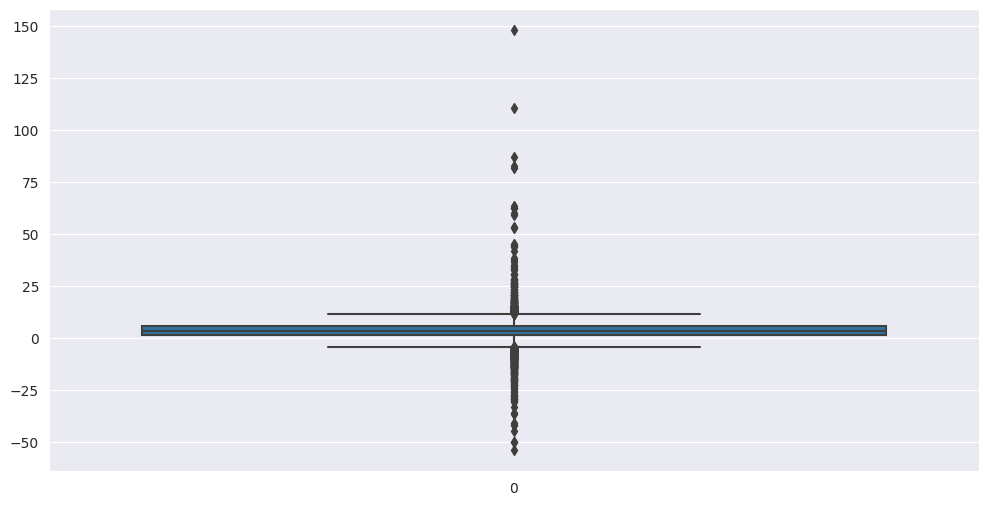

In [ ]:
#Gráfico de boxplot para verificação de outliers
plt.figure(figsize=(12,6))
sns.boxplot(df2['GDP'])
plt.show()

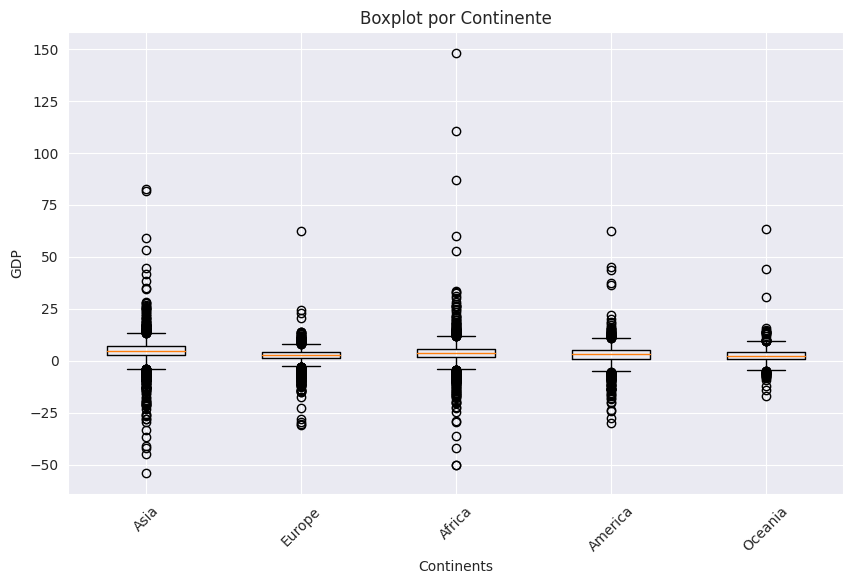

In [ ]:
# Boxplot por continente
plt.figure(figsize=(10, 6))
plt.title('Boxplot por Continente')
plt.xlabel('Continents')
plt.ylabel('GDP')
plt.boxplot([df2[df2['Continents'] == continent]['GDP'] for continent in df1['Continents'].unique()], labels=df1['Continents'].unique())
plt.xticks(rotation=45)
plt.show()

**Inferência:** Claramente, existem outliers. Entretanto, serão mantidos por se tratar de série temporal.

##3. Principais Análise estatísticas

In [ ]:
df2.describe()

GDP
count  9604.000000
mean      3.332034
std       5.824022
min     -54.200000
25%       1.500000
50%       3.410000
75%       5.500000
max     148.000000

**Univariate Analysis(Análise Univariada)**

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9604 entries, 0 to 9603
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Continents  9604 non-null   object 
 1   Country     9604 non-null   object 
 2   Year        9604 non-null   object 
 3   GDP         9604 non-null   float64
dtypes: float64(1), object(3)
memory usage: 300.2+ KB


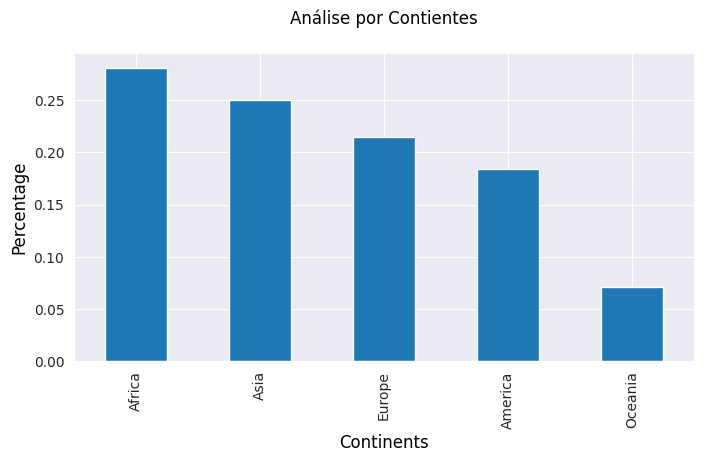

In [ ]:
#Distribuição por Continente
plt.figure(figsize= (8,4))
df2["Continents"].value_counts(normalize=True).plot.bar()
plt.title("Análise por Contientes\n", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.xlabel("Continents", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

**Inferência:** A África é o continete que representa a maior distribuição percentual no banco de dados. Essa análise pode ajudar a entender melhor a distribuição os dados.

Text(0.5, 0, 'GDP')

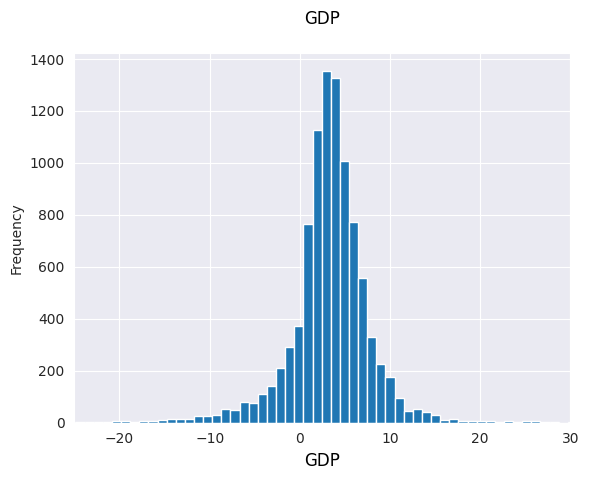

In [ ]:
#Histogrma do GDP
df2.GDP.plot.hist(bins=200)
plt.xlim(-25, 30)
plt.title("GDP\n", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.xlabel("GDP", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})

**Inferência:** A maior frequência situa-se entre 0 e 10.

**Bivariate Analysis (Análise Bivariada)**

In [ ]:
df2.head()

Continents      Country  Year   GDP
0       Asia  Afghanistan  1980  3.98
1     Europe      Albania  1980  2.70
2     Africa      Algeria  1980 -5.40
3     Europe      Andorra  1980  2.89
4     Africa       Angola  1980  2.40

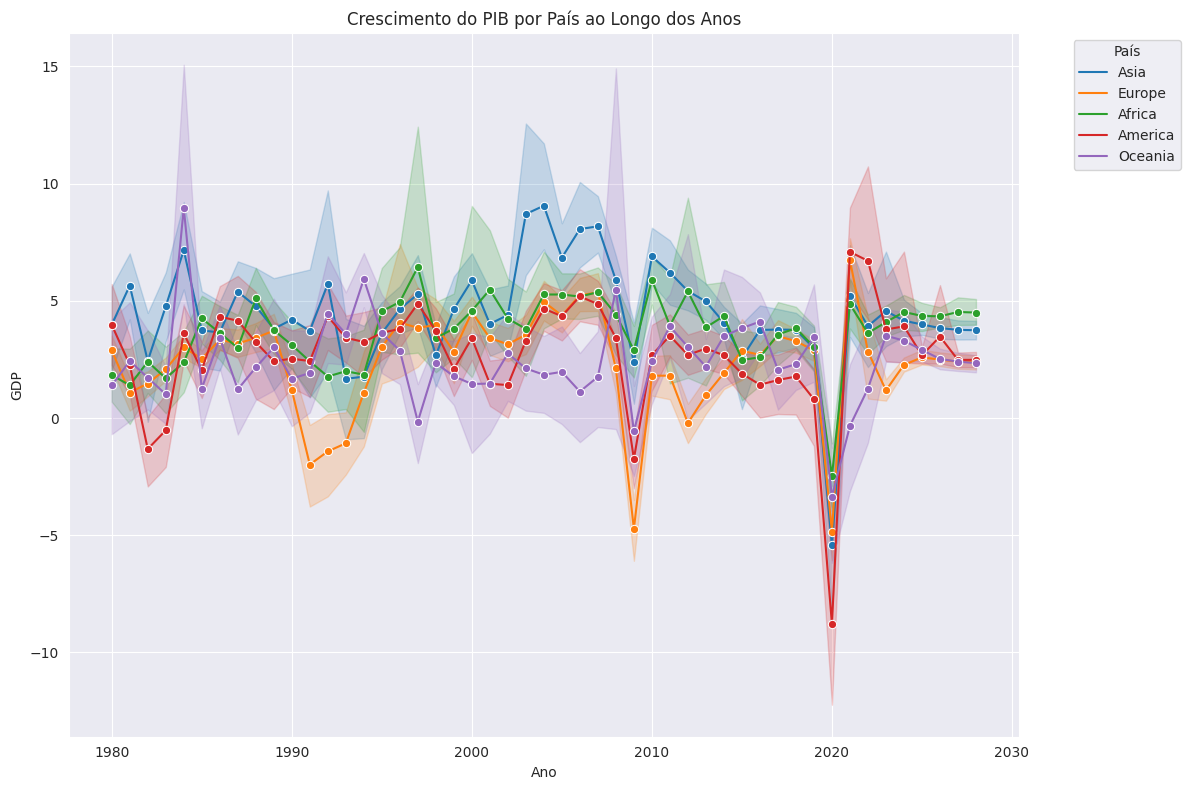

In [ ]:
# Gráfico de linha do GDP para todos os continetes
plt.figure(figsize=(12, 8))
sns.lineplot(data=df2, x='Year', y='GDP', hue='Continents', marker='o')
plt.xlabel("Ano")
plt.ylabel("GDP")
plt.title("Crescimento do PIB por País ao Longo dos Anos")
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


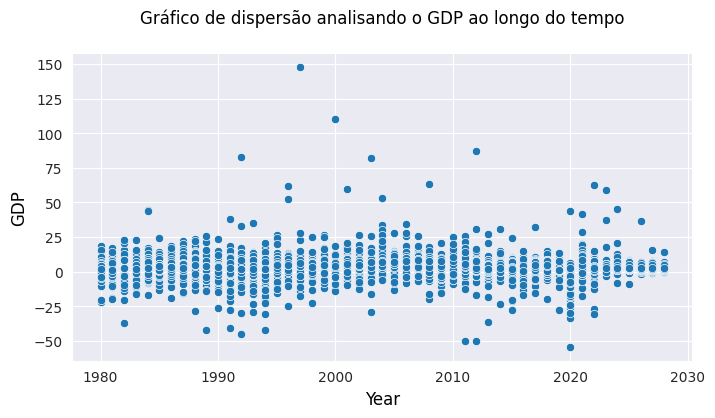

In [ ]:
# Gráfico de dispersão GDP ao longo do tempo.
plt.figure(figsize=[8, 4])
sns.scatterplot(x='Year', y='GDP', data=df2)
plt.title("Gráfico de dispersão analisando o GDP ao longo do tempo\n", fontdict={'fontsize': 12, 'fontweight': 5, 'color': 'Black'})
plt.xlabel("Year", fontdict={'fontsize': 12, 'fontweight': 5, 'color': 'Black'})
plt.ylabel("GDP", fontdict={'fontsize': 12, 'fontweight': 5, 'color': 'Black'})
plt.show()

**Inferência:** os dados mostram que há outliers e uma centralização do valores entre 25 e -25.

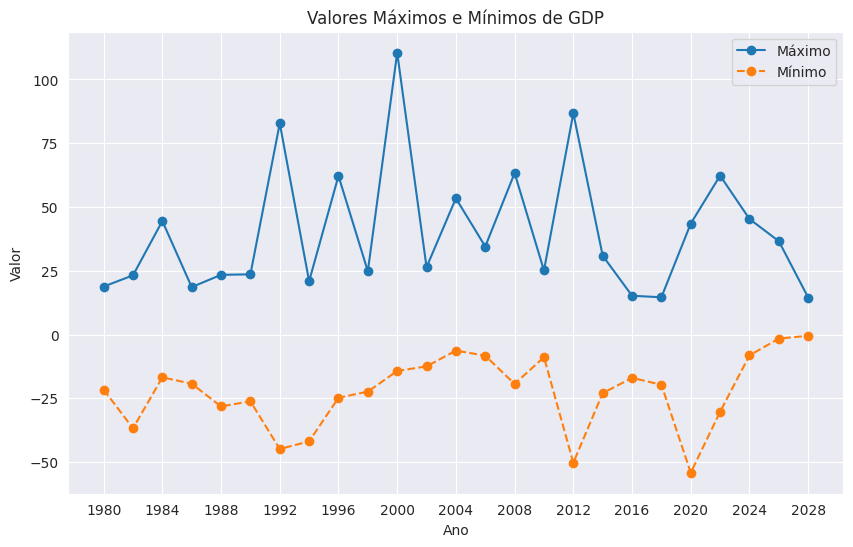

In [ ]:
# Máximo e Mínimo:

# Filtrar os dados de 2 em 2 anos
max_values_by_year = df2[df2['Year'] % 2 == 0].groupby('Year')['GDP'].max()
min_values_by_year = df2[df2['Year'] % 2 == 0].groupby('Year')['GDP'].min()

# Criar um gráfico de linha com valores máximos e mínimos por ano
plt.figure(figsize=(10, 6))
plt.plot(max_values_by_year.index, max_values_by_year.values, marker='o', label='Máximo')
plt.plot(min_values_by_year.index, min_values_by_year.values, marker='o', linestyle='dashed', label='Mínimo')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.title('Valores Máximos e Mínimos de GDP')
plt.legend()
plt.grid(True)

# Definir os valores do eixo x para mostrar de 2 em 2 anos
plt.xticks(max_values_by_year.index[::2])

plt.show()




**Inferência:** o ano de 2020 foi o de maior queda no GDP, provavelmente devido à pandemia do Covid.

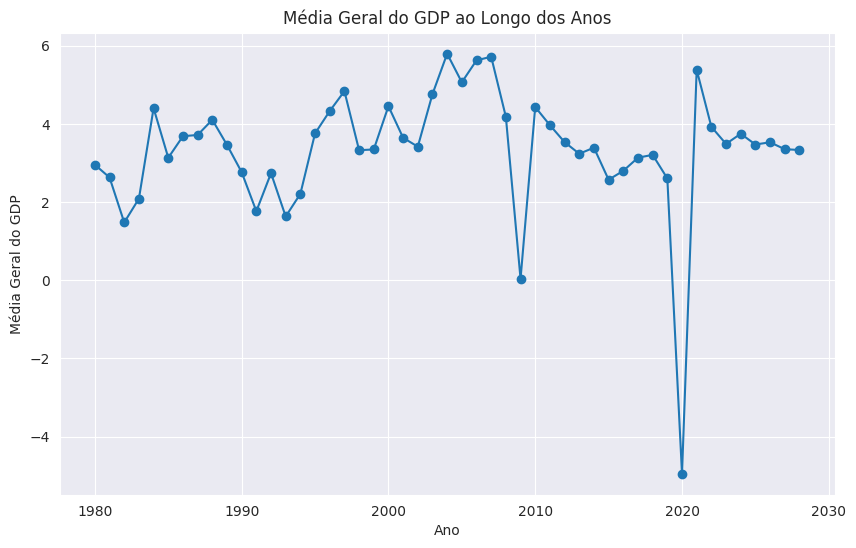

In [ ]:
# Calculando a média geral do GDP por ano
media_gdp_por_ano = df2.groupby('Year')['GDP'].mean()

# Gráfico de linha
plt.figure(figsize=(10, 6))
media_gdp_por_ano.plot(marker='o')
plt.title("Média Geral do GDP ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Média Geral do GDP")
plt.grid(True)
plt.show()

**Inferência:** analisando a média do GDP ao çongo do tempo, além do ano de 2020, o intevalo entre 2009 e 2010 também oocorreu uma queda do GDP.

<Figure size 1200x800 with 0 Axes>

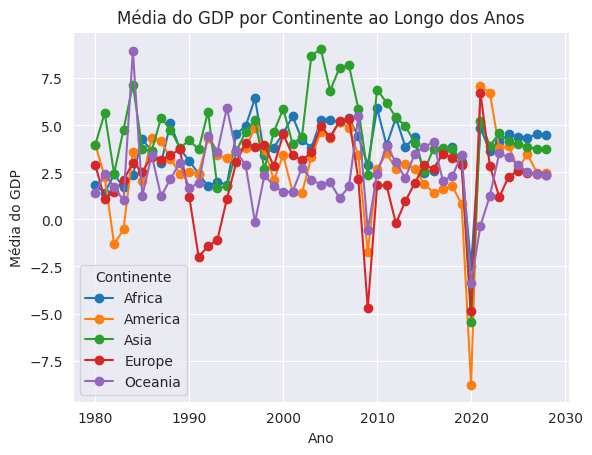

In [ ]:
# Média do GDP por continente e ano
continent_year_mean_gdp = df2.groupby(['Continents', 'Year'])['GDP'].mean().unstack()

# Plotando o gráfico de linha para cada continente
plt.figure(figsize=(12, 8))
continent_year_mean_gdp.T.plot(marker='o')
plt.xlabel('Ano')
plt.ylabel('Média do GDP')
plt.title('Média do GDP por Continente ao Longo dos Anos')
plt.legend(title='Continente')
plt.grid(True)
plt.show()



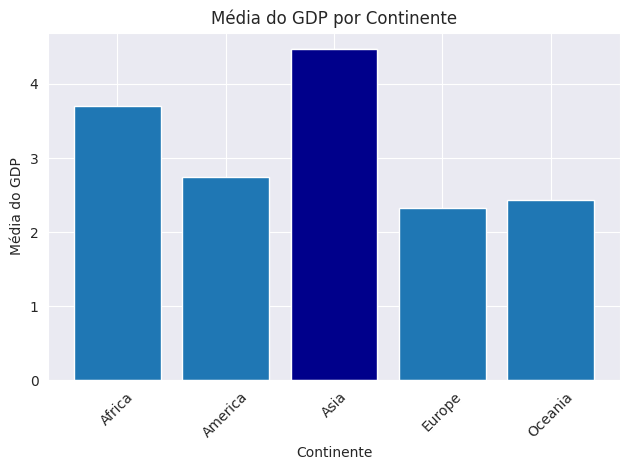

In [ ]:
# Média do GDP por continente
continent_mean_gdp = df2.groupby('Continents')['GDP'].mean()

# Encontrar o continente com o GDP mais discrepante
most_discrepant_continent = continent_mean_gdp.idxmax()

# Plotar o gráfico de barras
plt.bar(continent_mean_gdp.index, continent_mean_gdp.values)
plt.xlabel('Continente')
plt.ylabel('Média do GDP')
plt.title('Média do GDP por Continente')
plt.xticks(rotation=45)
plt.tight_layout()

# Destacar o continente mais discrepante com uma cor diferente
plt.bar(most_discrepant_continent, continent_mean_gdp[most_discrepant_continent], color='darkblue')

plt.show()


**Inferência:** A Ásia tem a maior média.

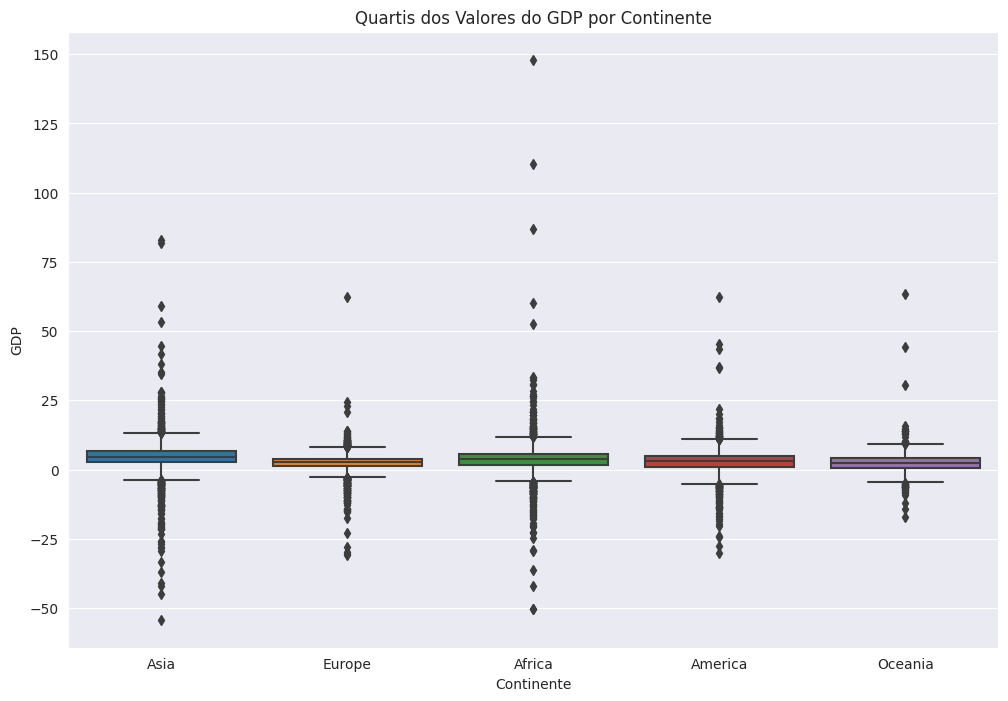

In [ ]:
# Boxplot quartis por contiente
plt.figure(figsize=(12, 8))
sns.boxplot(x='Continents', y='GDP', data=df2)

# Definir título e rótulos
plt.title('Quartis dos Valores do GDP por Continente')
plt.xlabel('Continente')
plt.ylabel('GDP')

# Exibir o gráfico
plt.show()



**Inferência:** Esse gárafico mostra a presença de outliers, notadamente na África.

#4. Preparação de dados e Modelagem

Para prvisão do GDP, serão utilizados os modelos ARIMA, SARIMA, Xgboost, RandomForestRegressor e o LinearRegression. Assim, podemos avaliar qual o melhor modelo.
O dataframe será dividido em treino e teste.
Treino:  serão considerados os anos de 1980 à 2023.
Teste: serão considerados os anos de 2024 à 2028.

As mértricas utilizadas serão:

**MSE:** penaliza erros maiores de forma mais significativa, sendo sensível a outliers, desa forma, é importante utilizá-lo uma vez que há outiers na série temporal.

**RMSE:** é a raiz quadrada do MSE e fornece uma medida da dispersão dos erros em relação aos valores reais. Ele é mais interpretável, pois está na mesma escala que os dados originais.

**MAPE:** O MAPE é útil para entender o erro médio em termos percentuais e é amplamente usado quando é importante avaliar erros relativos, especialmente em previsões que variam em magnitude.

##4.1 ARIMA

In [ ]:
# Cópia do dataframe original
data_arima = df1.copy()

# Define o período de previsão
forecast_years = range(2024, 2029)

# Listar de países únicos
countries = data_arima['Country'].unique()

# DataFrame para armazenar os resultados no formato correto
results_formatted = []

# Record the starting time
start_time = time.time()

# Loop através dos países
for country in countries:
    country_data = data_arima[data_arima['Country'] == country]

    # Dividir os dados em treinamento e teste
    train_data = country_data.iloc[:, 2:-len(forecast_years)]
    test_data = country_data.iloc[:, -len(forecast_years):]

    # Ajustar o modelo ARIMA automático e fazer previsões
    forecast_values = []

    for i in range(len(test_data)):
        actual_values = test_data.iloc[i, :].values

        # Ajustar o modelo ARIMA automático
        auto_model = pm.auto_arima(train_data.iloc[i, :])

        # Fazer previsões
        forecast, conf_int = auto_model.predict(n_periods=len(actual_values), return_conf_int=True)
        forecast_values.append(forecast)

    forecast_values = np.array(forecast_values)

    # Calcular o MAPE, MSE e RMSE
    actual_values = test_data.values
    mape = (np.abs(actual_values - forecast_values) / actual_values).mean(axis=1) * 100
    mse = mean_squared_error(actual_values, forecast_values, multioutput='raw_values')
    rmse = np.sqrt(mse)

    # Adicionar os resultados no formato correto ao DataFrame
    result_row = {
        'Continents': country_data['Continents'].values[0],
        'Country': country,
        **{str(year): forecast for year, forecast in zip(forecast_years, forecast_values[0])},
        'MAPE': mape.tolist()[0],  # Assume apenas um valor para MAPE
        'MSE': mse.tolist()[0],    # Assume apenas um valor para MSE
        'RMSE': rmse.tolist()[0]    # Assume apenas um valor para RMSE
    }
    results_formatted.append(result_row)

# Record the ending time
end_time = time.time()

# Calculate the elapsed time
execution_time = end_time - start_time

arima_time = execution_time

# Create a DataFrame with results in the correct format
predictions_arima = pd.DataFrame(results_formatted)

# Calculate the overall Mean Absolute Percentage Error (MAPE) average
overall_mape_average_arima = predictions_arima['MAPE'].mean()

# Calculate the overall Root Mean Squared Error (RMSE) average
overall_rmse_average_arima = predictions_arima['RMSE'].mean()

# Calculate the overall Mean Squared Error (MSE) average
overall_mse_average_arima = predictions_arima['MSE'].mean()

print("Predicted Model ARIMA:")
# Display the elapsed time
print("Time taken:", arima_time, "seconds")
# Display the overall MAPE average
print("Overall MAPE Average:", overall_mape_average_arima)
# Display the overall RMSE average
print("Overall RMSE Average:", overall_rmse_average_arima)
# Display the overall MSE average
print("Overall MSE Average:", overall_mse_average_arima)

predictions_arima


Predicted Model ARIMA:
Time taken: 201.15065670013428 seconds
Overall MAPE Average: 36.189878870300774
Overall RMSE Average: 1.687491384624581
Overall MSE Average: 18.043601302554617


Continents                           Country       2024       2025  \
0         Asia                       Afghanistan   3.466772   5.757505   
1       Europe                           Albania   3.738784   2.832769   
2       Africa                           Algeria   2.438544   2.385327   
3       Europe                           Andorra   1.717591   1.868382   
4       Africa                            Angola   4.048752   4.359105   
5      America               Antigua and Barbuda   3.889696   3.386085   
6      America                         Argentina   1.811364   1.811364   
7         Asia                           Armenia   4.841402   5.131074   
8      America                             Aruba   3.435909   3.435909   
9      Oceania                         Australia   3.560694   2.707185   
10      Europe                           Austria   1.847727   1.847727   
11        Asia                        Azerbaijan   3.215050   3.751793   
12     America                      Bahamas, The   1.875000   1.875000   
13        Asia                           Bahrain   3.619952   3.824441   
14        Asia                        Bangladesh   6.245608   6.245608   
15     America                          Barbados   0.709083   0.000000   
16      Europe                           Belarus   0.503112   0.361603   
17      Europe                           Belgium   1.863636   1.863636   
18     America                            Belize   4.079945   4.787319   
19      Africa                             Benin   5.317031   5.317031   
20        Asia                            Bhutan   5.006833   6.556531   
21     America                           Bolivia   2.291018   2.342369   
22      Europe            Bosnia and Herzegovina   3.464892   4.234851   
23      Africa                          Botswana   3.788466   3.788466   
24     America                            Brazil   2.293182   2.293182   
25        Asia                 Brunei Darussalam   3.300000   3.300000   
26      Europe                          Bulgaria   2.752412   1.100278   
27      Africa                      Burkina Faso   4.909091   4.909091   
28      Africa                           Burundi   1.800715   2.772921   
29      Africa                        Cabo Verde   5.093182   5.093182   
30        Asia                          Cambodia   6.359386   6.267719   
31      Africa                          Cameroon   4.161726   4.059939   
32     America                            Canada   2.290909   2.290909   
33      Africa          Central African Republic   0.000000   0.000000   
34      Africa                              Chad   4.097978   4.356286   
35     America                             Chile   4.050000   4.050000   
36        Asia       China, People's Republic of   6.664444   7.541137   
37     America                          Colombia   3.438636   3.438636   
38      Africa                           Comoros   2.557912   2.744100   
39      Africa           Congo, Dem. Rep. of the   6.300000   6.300000   
40      Africa               Congo, Republic of    3.120455   3.120455   
41     America                        Costa Rica   3.489149   3.677523   
42      Europe                           Croatia   2.221136   2.221136   
43      Europe                            Cyprus   3.232143   3.232143   
44      Europe                    Czech Republic   1.393184   2.072408   
45      Africa                     Côte d'Ivoire   5.640327   5.413083   
46      Europe                           Denmark   1.763636   1.763636   
47      Africa                          Djibouti   3.247974   3.487788   
48     America                          Dominica   1.200827   1.200827   
49     America                Dominican Republic   4.593182   4.593182   
50     America                           Ecuador   2.686364   2.686364   
51      Africa                             Egypt   4.695410   4.842750   
52     America                       El Salvador   2.062476   1.887388   
53      

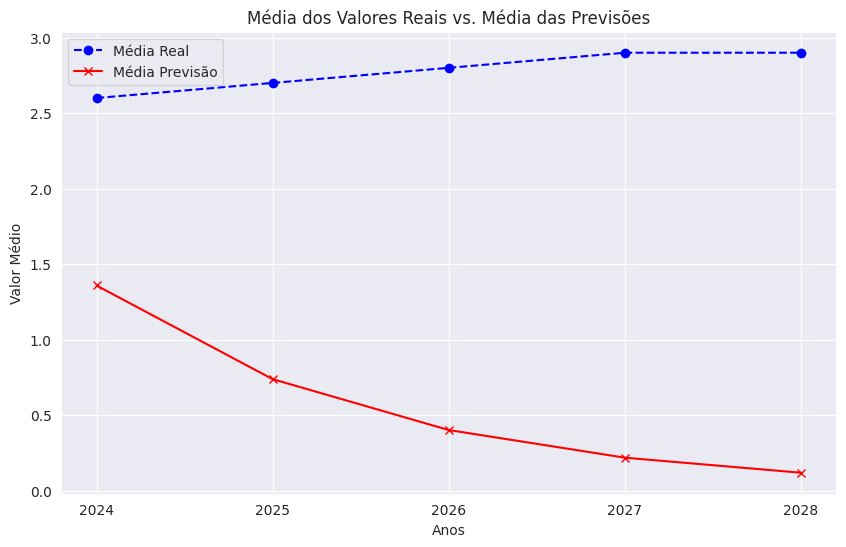

In [ ]:
# 'actual_values': valores reais e 'forecast_values': previsões do modelo

# Calcular as médias das previsões e dos valores reais para cada ano
mean_actual_values = actual_values.mean(axis=0)
mean_forecast_values = forecast_values.mean(axis=0)

# Anos de 2024 a 2028
anos = range(2024, 2029)

# Plotar os resultados médios
plt.figure(figsize=(10, 6))
plt.plot(anos, mean_actual_values, marker='o', label='Média Real', linestyle='dashed', color='b')
plt.plot(anos, mean_forecast_values, marker='x', label='Média Previsão', color='r')

plt.xlabel('Anos')
plt.ylabel('Valor Médio')
plt.title('Média dos Valores Reais vs. Média das Previsões')
plt.xticks(anos)  # Definir os valores dos anos no eixo x
plt.legend()
plt.grid(True)
plt.show()


**Inferência:** nitidamente, o modelo se comporta de forma distante dos valores reais.

##4.2 SARIMA

In [ ]:
# Faz uma cópia do dataframe original
data_sarima = df1.copy()

# Definir o período de previsão
forecast_years = range(2024, 2029)

# Lista de países únicos
countries = data_sarima['Country'].unique()

# Função para ajustar o modelo SARIMA e fazer previsões
def fit_sarima_and_forecast(train_data, test_data, p, d, q, P, D, Q, S):
    model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test_data))

    return forecast

# DataFrame para armazenar os resultados no formato correto
results_formatted = []

# Record the starting time
start_time = time.time()

# Loop através dos países
for country in countries:
    country_data = data_sarima[data_sarima['Country'] == country]

    # Dividir os dados em treinamento e teste
    train_data = country_data.iloc[:, 2:-len(forecast_years)]
    test_data = country_data.iloc[:, -len(forecast_years):]

    # Ajustar o modelo SARIMA e fazer previsões (substitua os valores de p, d, q, P, D, Q, S pelos apropriados para cada país)
    p, d, q, P, D, Q, S = 1, 1, 1, 1, 1, 1, 12  # Substitua esses valores pelos apropriados para cada país
    forecast_values = []

    for i in range(len(test_data)):
        actual_values = test_data.iloc[i, :].values
        forecast = fit_sarima_and_forecast(train_data.iloc[i, :], actual_values, p, d, q, P, D, Q, S)
        forecast_values.append(forecast)

    forecast_values = np.array(forecast_values)

    # Calcular o MAPE, MSE e RMSE
    actual_values = test_data.values
    mape = (np.abs(actual_values - forecast_values) / actual_values).mean(axis=1) * 100
    mse = mean_squared_error(actual_values, forecast_values, multioutput='raw_values')
    rmse = np.sqrt(mse)

    # Adicionar os resultados no formato correto ao DataFrame
    result_row = {
        'Continents': country_data['Continents'].values[0],
        'Country': country,
        **{str(year): forecast for year, forecast in zip(forecast_years, forecast_values[0])},
        'MAPE': mape.tolist()[0],  # Assume apenas um valor para MAPE
        'MSE': mse.tolist()[0],    # Assume apenas um valor para MSE
        'RMSE': rmse.tolist()[0]    # Assume apenas um valor para RMSE
    }
    results_formatted.append(result_row)

# Calcular o tempo de execução total
end_time = time.time()
sarima_time = end_time - start_time

# Create a DataFrame with results in the correct format
predictions_sarima = pd.DataFrame(results_formatted)

# Calculate the overall Mean Absolute Percentage Error (MAPE) average
overall_mape_average_sarima = predictions_sarima['MAPE'].mean()

# Calculate the overall Root Mean Squared Error (RMSE) average
overall_rmse_average_sarima = predictions_sarima['RMSE'].mean()

# Calculate the overall Mean Squared Error (MSE) average
overall_mse_average_sarima = predictions_sarima['MSE'].mean()

print("Predicted Model SARIMA:")
# Display the elapsed time
print("Time taken:", execution_time, "seconds")
# Display the overall MAPE average
print("Overall MAPE Average:", overall_mape_average_sarima)
# Display the overall RMSE average
print("Overall RMSE Average:", overall_rmse_average_sarima)
# Display the overall MSE average
print("Overall MSE Average:", overall_mse_average_sarima)

predictions_sarima


Predicted Model SARIMA:
Time taken: 0.419628381729126 seconds
Overall MAPE Average: 95.76317789512333
Overall RMSE Average: 3.24745291431448
Overall MSE Average: 55.95230457986758


Continents                           Country       2024       2025  \
0         Asia                       Afghanistan   6.161723   2.630943   
1       Europe                           Albania   2.061075   5.511461   
2       Africa                           Algeria   3.031704   2.770362   
3       Europe                           Andorra  -2.229409  -0.120675   
4       Africa                            Angola   3.860660   0.272897   
5      America               Antigua and Barbuda   3.863032  -1.832343   
6      America                         Argentina  -1.974479  -4.170742   
7         Asia                           Armenia   6.700555   7.151972   
8      America                             Aruba   6.898198   5.027181   
9      Oceania                         Australia   2.789442   1.419723   
10      Europe                           Austria   0.861061   0.990559   
11        Asia                        Azerbaijan   2.453867   6.027309   
12     America                      Bahamas, The   2.438288  -2.397032   
13        Asia                           Bahrain   3.244026   1.816051   
14        Asia                        Bangladesh   8.189860   7.547868   
15     America                          Barbados   2.996387   0.049461   
16      Europe                           Belarus   3.671977   2.797890   
17      Europe                           Belgium   1.454746   0.056090   
18     America                            Belize   4.539436   1.896270   
19      Africa                             Benin   6.601465   8.660663   
20        Asia                            Bhutan   0.374646  -3.004385   
21     America                           Bolivia   2.124129   2.453587   
22      Europe            Bosnia and Herzegovina  -0.134310   0.468233   
23      Africa                          Botswana   8.180634   2.067084   
24     America                            Brazil   2.356743   1.279610   
25        Asia                 Brunei Darussalam   0.199359  -2.377983   
26      Europe                          Bulgaria   5.064717   4.145265   
27      Africa                      Burkina Faso   5.593709   5.045354   
28      Africa                           Burundi   1.450812   2.808434   
29      Africa                        Cabo Verde   1.986927   1.418095   
30        Asia                          Cambodia   5.614709   5.884494   
31      Africa                          Cameroon   4.466167   6.240969   
32     America                            Canada   2.756920   1.654595   
33      Africa          Central African Republic   2.218670 -25.547396   
34      Africa                              Chad   5.597684   7.652996   
35     America                             Chile   2.342350  -0.932121   
36        Asia       China, People's Republic of   4.085106   3.347534   
37     America                          Colombia   3.751642   3.281629   
38      Africa                           Comoros   1.692078   2.708337   
39      Africa           Congo, Dem. Rep. of the   2.516844   5.681886   
40      Africa               Congo, Republic of   11.310148   1.113382   
41     America                        Costa Rica   2.800328   0.777272   
42      Europe                           Croatia   2.621339   2.615833   
43      Europe                            Cyprus  -2.211518  -6.168740   
44      Europe                    Czech Republic  -0.023726   0.901877   
45      Africa                     Côte d'Ivoire   5.767861   6.666293   
46      Europe                           Denmark   0.614229   0.324364   
47      Africa                          Djibouti   3.180219   3.186012   
48     America                          Dominica  -1.775982  -3.200207   
49     America                Dominican Republic   4.110843   4.382359   
50     America                           Ecuador   0.803408   3.320111   
51      Africa                             Egypt   3.510047   2.972645   
52     America                       El Salvador   2.788266   1.925493   
53      

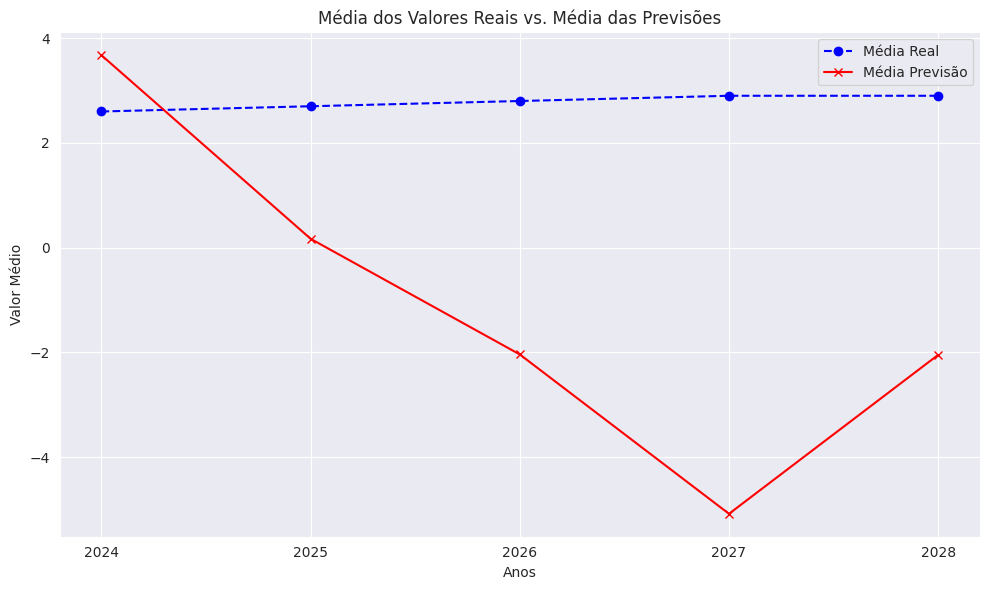

In [ ]:
# Calcular as médias das previsões e dos valores reais para cada ano
mean_actual_values = actual_values.mean(axis=0)
mean_forecast_values = forecast_values.mean(axis=0)

# Anos de 2024 a 2028
anos = range(2024, 2029)

# Plotar os resultados médios
plt.figure(figsize=(10, 6))
plt.plot(anos, mean_actual_values, marker='o', label='Média Real', linestyle='dashed', color='b')
plt.plot(anos, mean_forecast_values, marker='x', label='Média Previsão', color='r')

plt.xlabel('Anos')
plt.ylabel('Valor Médio')
plt.title('Média dos Valores Reais vs. Média das Previsões')
plt.xticks(anos)  # Definir os valores dos anos no eixo x
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

**Inferência:**  o modelo SARIMA também se comporta de forma distante dos valores reais.

##4.3 Xgboost

In [ ]:
# Faz uma cópia do dataframe original
data_xgbregressor = df1.copy()

# Definir as colunas de treino (1980 a 2023) e colunas alvo (2024 a 2028)
cols_train = [str(year) for year in range(1980, 2029)]  # Incluindo 2028
cols_target = [str(year) for year in range(2024, 2029)]

# Transformar os índices das colunas em strings
data_xgbregressor.columns = data_xgbregressor.columns.astype(str)

# Dividir o conjunto de dados em características (X) e colunas alvo (y)
X_train = data_xgbregressor.loc[:, cols_train[:-5]]  # Excluindo os últimos 5 anos
y_train = data_xgbregressor.loc[:, cols_target]
X_test = data_xgbregressor.loc[:, cols_train[:-5]]  # Excluindo os últimos 5 anos
y_test = data_xgbregressor.loc[:, cols_target]

# Registrar o tempo de início
start_time = time.time()

# Criar um modelo XGBoost com hiperparâmetros ajustados
model = XGBRegressor(
    learning_rate=0.1,
    n_estimators=55,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
predictions_xg = model.predict(X_test)

# Calcular o Mean Squared Error (MSE) e o Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predictions_xg)
rmse = np.sqrt(mse)

# Criar DataFrame com as previsões para cada ano
predictions_df_xg = pd.DataFrame(predictions_xg, columns=cols_target)
predictions_df_xg['Country'] = data_xgbregressor['Country'].values  # Adicionar a coluna 'Country'
predictions_df_xg['Continents'] = data_xgbregressor['Continents'].values  # Adicionar a coluna 'Continent'

# Reorganizar as colunas
predictions_df_xg = predictions_df_xg[['Continents', 'Country'] + cols_target]

# Definir o índice para começar em 1
predictions_df_xg.index = predictions_df_xg.index + 1

# Calcular o Mean Absolute Percentage Error (MAPE) para cada país
mape_per_country = []

for i, row in y_test.iterrows():
    country = data_xgbregressor.loc[i, 'Country']
    actual = row.values
    predicted = predictions_df_xg.loc[i, cols_target].values
    absolute_percentage_errors = abs((actual - predicted) / actual) * 100
    mape_per_country.append({'Country': country, 'MAPE': absolute_percentage_errors.mean()})

# Criar um DataFrame com o MAPE para cada país
mape_df_xg = pd.DataFrame(mape_per_country)

# Calcular a média geral do MAPE
overall_mape_xg_average = mape_df_xg['MAPE'].mean()

# Adicionar o MAPE ao DataFrame de previsões
predictions_df_xg = pd.merge(predictions_df_xg, mape_df_xg, on='Country')

# Definir o índice para começar em 1
predictions_df_xg.index = predictions_df_xg.index + 1

# Calcular o Mean Squared Error (MSE) para cada país
mse_per_country = []

for i, row in y_test.iterrows():
    country = data_xgbregressor.loc[i, 'Country']
    actual = row.values
    predicted = predictions_df_xg.loc[i, cols_target].values
    mse = mean_squared_error(actual, predicted)
    mse_per_country.append({'Country': country, 'MSE': mse})

# Criar um DataFrame com o MSE para cada país
mse_df_xg = pd.DataFrame(mse_per_country)

# Adicionar o RMSE a cada linha
mse_df_xg['RMSE'] = rmse

# Calcular a média geral do MSE
overall_mse_xg_average = mse_df_xg['MSE'].mean()

# Calcular a média geral do MSE
overall_rmse_xg_average = mse_df_xg['RMSE'].mean()

# Adicionar o RMSE e o MSE ao DataFrame de previsões
predictions_df_xg['RMSE'] = rmse
predictions_df_xg['MSE'] = mse_df_xg['MSE']

# Calcular o tempo de execução total
end_time = time.time()
execution_time = end_time - start_time
xgboost_time = execution_time

# Exibir o DataFrame com previsões, MAPE, MSE e RMSE para cada país
print("Predicted Model XGBRegressor:")
# Exibir a média geral do MAPE
print("Overall MAPE Average:", overall_mape_xg_average)
# Exibir a média geral do RMSE
print("Overall RMSE Average:", overall_rmse_xg_average)
# Exibir a média geral do MSE
print("Overall MSE Average:", overall_mse_xg_average)
# Exibir o tempo de execução
print("Execution Time:", xgboost_time, "seconds")

# Exibir o DataFrame com as previsões
predictions_df_xg


Predicted Model XGBRegressor:
Overall MAPE Average: 12.44727241748643
Overall RMSE Average: 0.47046731614701537
Overall MSE Average: 0.22133949556257565
Execution Time: 3.1477599143981934 seconds


Continents                           Country       2024      2025  \
1         Asia                       Afghanistan   4.368382  4.196601   
2       Europe                           Albania   2.934777  3.317583   
3       Africa                           Algeria   2.658115  2.664775   
4       Europe                           Andorra   1.866981  2.034504   
5       Africa                            Angola   3.532041  3.602193   
6      America               Antigua and Barbuda   4.982080  4.254604   
7      America                         Argentina   2.001169  2.045358   
8         Asia                           Armenia   4.880384  4.845984   
9      America                             Aruba   1.821591  1.635021   
10     Oceania                         Australia   1.782110  2.155785   
11      Europe                           Austria   1.340961  1.706282   
12        Asia                        Azerbaijan   2.471773  2.836532   
13     America                      Bahamas, The   2.908751  2.153372   
14        Asia                           Bahrain   3.173926  3.162872   
15        Asia                        Bangladesh   5.647759  6.097208   
16     America                          Barbados   3.716063  2.800020   
17      Europe                           Belarus   1.870768  1.683731   
18      Europe                           Belgium   1.183234  1.462189   
19     America                            Belize   2.281027  2.123824   
20      Africa                             Benin   5.856009  5.974032   
21        Asia                            Bhutan   4.137084  4.862477   
22     America                           Bolivia   2.794202  3.190905   
23      Europe            Bosnia and Herzegovina   2.267406  3.095288   
24      Africa                          Botswana   4.123462  4.054641   
25     America                            Brazil   1.960556  1.839908   
26        Asia                 Brunei Darussalam   3.261309  2.788933   
27      Europe                          Bulgaria   2.896780  2.893806   
28      Africa                      Burkina Faso   5.763212  5.798921   
29      Africa                           Burundi   4.519616  4.771154   
30      Africa                        Cabo Verde   4.929168  4.940387   
31        Asia                          Cambodia   5.995776  6.212363   
32      Africa                          Cameroon   4.441513  4.349390   
33     America                            Canada   1.673197  2.041374   
34      Africa          Central African Republic   3.400733  3.345620   
35      Africa                              Chad   3.603843  3.510742   
36     America                             Chile   2.000921  2.559810   
37        Asia       China, People's Republic of   5.055420  4.360542   
38     America                          Colombia   2.244914  2.953746   
39      Africa                           Comoros   3.338505  3.523966   
40      Africa           Congo, Dem. Rep. of the   6.552708  6.954202   
41      Africa               Congo, Republic of    3.895307  3.634714   
42     America                        Costa Rica   2.977313  2.959045   
43      Europe                           Croatia   2.393860  2.320842   
44      Europe                            Cyprus   2.995594  3.098798   
45      Europe                    Czech Republic   1.989882  3.052412   
46      Africa                     Côte d'Ivoire   6.952737  6.027669   
47      Europe                           Denmark   1.408272  1.727266   
48      Africa                          Djibouti   5.273130  5.208930   
49     America                          Dominica   4.336096  4.241702   
50     America                Dominican Republic   4.797186  4.710129   
51     America                           Ecuador   2.728430  2.862975   
52      Africa                             Egypt   4.543970  4.900555   
53     America                       El Salvador   2.176735  1.906280   
54      Africa                 Equatorial Guinea  -6.365920 -7

Os hiperarâmetros vão ajustar o modelo, pois controlam o processo de construção do modelo XGBoost e influenciam seu desempenho, bem como a capacidade de lidar com o overfitting.

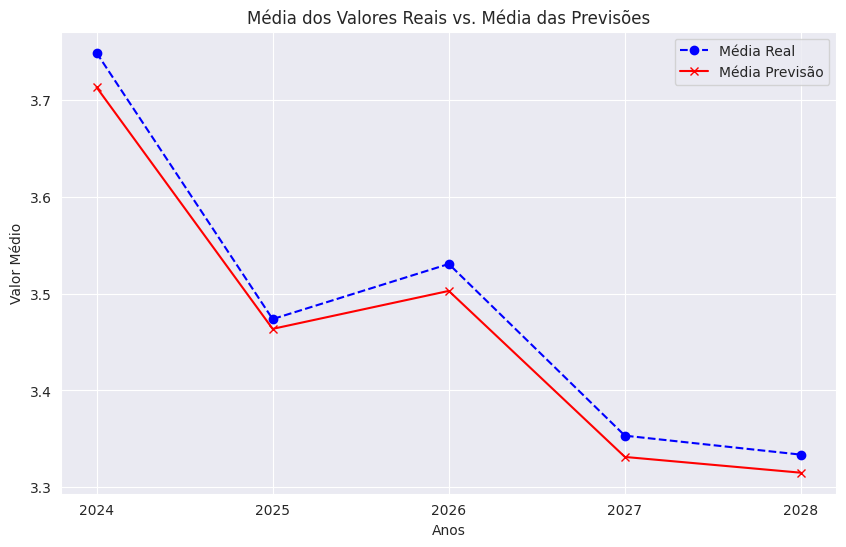

In [ ]:
# 'y_test': valores reais e 'predictions': previsões do modelo

# Calcular as médias das previsões e dos valores reais para cada ano
mean_y_test = y_test.mean(axis=0)
mean_predictions = np.mean(predictions_xg, axis=0)

# Anos de 2024 a 2028
anos = range(2024, 2029)

# Plotar os resultados médios
plt.figure(figsize=(10, 6))
plt.plot(anos, mean_y_test, marker='o', label='Média Real', linestyle='dashed', color='b')
plt.plot(anos, mean_predictions, marker='x', label='Média Previsão', color='r')

plt.xlabel('Anos')
plt.ylabel('Valor Médio')
plt.title('Média dos Valores Reais vs. Média das Previsões')
plt.xticks(anos)  # Definir os valores dos anos no eixo x
plt.legend()
plt.grid(True)
plt.show()


**Inferência:** o modelo funciona bem, a média da previsão acompanha a média dos valores reais.

##4.4 RandomForestRegressor

In [ ]:
# Faz uma cópia do dataframe original
data_rfregressor = df1.copy()

# Define as colunas de treinamento (1980 a 2023) e colunas alvo (2024 a 2028)
cols_train = [str(year) for year in range(1980, 2029)]  # Including 2028
cols_target = [str(year) for year in range(2024, 2029)]

# Converte os índices de coluna para strings
data_rfregressor.columns = data_rfregressor.columns.astype(str)

# Separa o conjunto de dados em features (X) e colunas alvo (y) para treinamento e teste
X_train = data_rfregressor.loc[:, cols_train[:-5]]  # Excluindo os últimos 5 anos
y_train = data_rfregressor.loc[:, cols_target]
X_test = data_rfregressor.loc[:, cols_train[:-5]]  # Excluindo os últimos 5 anos
y_test = data_rfregressor.loc[:, cols_target]

# Registrar o tempo de início
start_time = time.time()

# Cria um modelo RandomForestRegressor com hiperparâmetros ajustados
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões
predictions_rf = model.predict(X_test)

# Calcula o Mean Squared Error (MSE) e Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predictions_rf)
rmse = np.sqrt(mse)

# Cria um DataFrame com as previsões para cada ano
predictions_df_rf = pd.DataFrame(predictions_rf, columns=cols_target)
predictions_df_rf['Country'] = data_rfregressor['Country'].values  # Adiciona a coluna 'Country'
predictions_df_rf['Continents'] = data_rfregressor['Continents'].values  # Adiciona a coluna 'Continent'

# Reorganiza as colunas do DataFrame
predictions_df_rf = predictions_df_rf[['Continents', 'Country'] + cols_target]

# Ajusta o índice para começar a partir de 1
predictions_df_rf.index = predictions_df_rf.index + 1

# Calcula o Mean Absolute Percentage Error (MAPE) para cada país
mape_per_country = []

for i, row in y_test.iterrows():
    country = data_rfregressor.loc[i, 'Country']
    actual = row.values
    predicted = predictions_df_rf.loc[i, cols_target].values
    absolute_percentage_errors = abs((actual - predicted) / actual) * 100
    mape_per_country.append({'Country': country, 'MAPE': absolute_percentage_errors.mean()})

# Cria um DataFrame com o MAPE para cada país
mape_df_rf = pd.DataFrame(mape_per_country)

# Calcula a média geral do MAPE
overall_mape_rf_average = mape_df_rf['MAPE'].mean()

# Adiciona o MAPE ao DataFrame de previsões
predictions_df_rf = pd.merge(predictions_df_rf, mape_df_rf, on='Country')

# Ajusta o índice para começar a partir de 1
predictions_df_rf.index = predictions_df_rf.index + 1

# Calcula o Mean Squared Error (MSE) para cada país
rmse_per_country = []

for i, row in y_test.iterrows():
    country = data_rfregressor.loc[i, 'Country']
    actual = row.values
    predicted = predictions_df_rf.loc[i, cols_target].values
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)  # Calcula o RMSE correspondente ao MSE
    rmse_per_country.append({'Country': country, 'MSE': mse, 'RMSE': rmse})

# Cria um DataFrame com o MSE e RMSE para cada país
rmse_df_rf = pd.DataFrame(rmse_per_country)

# Calcula a média geral do RMSE
overall_rmse_rf_average = rmse_df_rf['RMSE'].mean()

# Calcula a média geral do RMSE
overall_mse_rf_average = rmse_df_rf['MSE'].mean()


# Calcula o tempo de execução total
end_time = time.time()
execution_time = end_time - start_time
rf_time = execution_time


# Adiciona o MSE, RMSE e tempo de execução ao DataFrame de previsões
predictions_df_rf = pd.merge(predictions_df_rf, rmse_df_rf, on='Country')

# Exibe as previsões, MAPE, RMSE e tempo de execução para cada país
print("Predicted Model RandomForestRegressor:")
# Exibe a média geral do MAPE
print("Overall MAPE Average:", overall_mape_rf_average)
# Exibe a média geral do RMSE
print("Overall RMSE Average:", overall_rmse_rf_average)
# Exibe a média geral do RMSE
print("Overall MSE Average:", overall_mse_rf_average)
# Exibe o tempo de execução
print("Execution Time:", rf_time, "seconds")

# Exibe o DataFrame com as previsões
predictions_df_rf


Predicted Model RandomForestRegressor:
Overall MAPE Average: 11.768491634441578
Overall RMSE Average: 0.3748476352692133
Overall MSE Average: 0.5997775908866725
Execution Time: 0.8890738487243652 seconds


Continents                           Country       2024      2025  \
0         Asia                       Afghanistan   4.251030  4.075367   
1       Europe                           Albania   3.105208  3.181060   
2       Africa                           Algeria   2.493662  2.413316   
3       Europe                           Andorra   1.695918  1.862657   
4       Africa                            Angola   3.725860  3.804484   
5      America               Antigua and Barbuda   5.361238  4.429562   
6      America                         Argentina   2.048162  2.110109   
7         Asia                           Armenia   5.465665  4.909838   
8      America                             Aruba   1.635613  1.759789   
9      Oceania                         Australia   1.858432  2.160731   
10      Europe                           Austria   1.253274  1.713488   
11        Asia                        Azerbaijan   2.645457  2.685811   
12     America                      Bahamas, The   2.668654  2.409295   
13        Asia                           Bahrain   3.404634  3.078416   
14        Asia                        Bangladesh   6.130215  6.567438   
15     America                          Barbados   4.094035  3.113700   
16      Europe                           Belarus   1.778786  1.891442   
17      Europe                           Belgium   1.232554  1.488458   
18     America                            Belize   2.146680  2.202423   
19      Africa                             Benin   5.991819  5.911410   
20        Asia                            Bhutan   3.809951  5.005654   
21     America                           Bolivia   2.411452  2.691495   
22      Europe            Bosnia and Herzegovina   2.864201  2.997324   
23      Africa                          Botswana   4.093431  3.935243   
24     America                            Brazil   1.712282  2.041405   
25        Asia                 Brunei Darussalam   3.405031  3.056269   
26      Europe                          Bulgaria   3.122308  2.941194   
27      Africa                      Burkina Faso   5.554834  5.563605   
28      Africa                           Burundi   4.886429  4.848660   
29      Africa                        Cabo Verde   4.997727  4.782984   
30        Asia                          Cambodia   6.183637  6.307193   
31      Africa                          Cameroon   4.452882  4.543903   
32     America                            Canada   1.549990  2.144299   
33      Africa          Central African Republic   3.406043  3.482161   
34      Africa                              Chad   3.689461  3.579167   
35     America                             Chile   2.209457  2.485160   
36        Asia       China, People's Republic of   5.290481  4.683336   
37     America                          Colombia   2.317302  2.889665   
38      Africa                           Comoros   3.255954  3.619211   
39      Africa           Congo, Dem. Rep. of the   6.725186  6.361700   
40      Africa               Congo, Republic of    4.330814  3.584914   
41     America                        Costa Rica   2.891001  3.093446   
42      Europe                           Croatia   2.345211  2.707521   
43      Europe                            Cyprus   2.891520  3.076554   
44      Europe                    Czech Republic   2.297971  3.042334   
45      Africa                     Côte d'Ivoire   6.625500  5.912722   
46      Europe                           Denmark   1.216642  1.535976   
47      Africa                          Djibouti   5.679856  5.415189   
48     America                          Dominica   4.482445  4.058185   
49     America                Dominican Republic   4.982406  4.980594   
50     America                           Ecuador   2.750671  2.782247   
51      Africa                             Egypt   4.659502  5.064353   
52     America                       El Salvador   1.984186  2.125048   
53      Africa                 Equatorial Guinea  -3.881889 -3

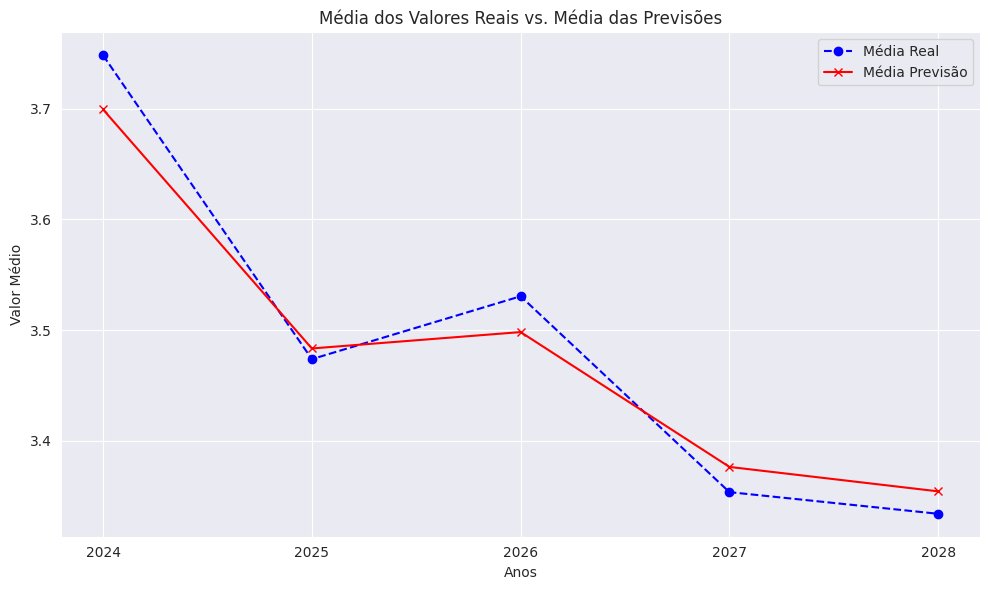

In [ ]:
# 'y_test': valores reais e 'predictions': previsões do modelo

# Calcular as médias das previsões e dos valores reais para cada ano
mean_y_test = y_test.mean(axis=0)
mean_predictions = np.mean(predictions_rf, axis=0)

# Anos de 2024 a 2028
anos = range(2024, 2029)

# Plotar os resultados médios
plt.figure(figsize=(10, 6))
plt.plot(anos, mean_y_test, marker='o', label='Média Real', linestyle='dashed', color='b')
plt.plot(anos, mean_predictions, marker='x', label='Média Previsão', color='r')

plt.xlabel('Anos')
plt.ylabel('Valor Médio')
plt.title('Média dos Valores Reais vs. Média das Previsões')
plt.xticks(anos)  # Definir os valores dos anos no eixo x
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


**Inferência:** o modelo RandomForestRegressor se aproximou aos valores reais, ao anlisarmos a média do valores reais e previstos no gráfico.

##4.5 LinearRegression

In [ ]:
# Faz uma cópia do dataframe original
data_lrregressor = df1.copy()

# Define as colunas de treinamento (1980 a 2023) e colunas alvo (2024 a 2028)
cols_train = [str(year) for year in range(1980, 2029)]
cols_target = [str(year) for year in range(2024, 2029)]

# Converte os índices de coluna para strings
data_lrregressor.columns = data_lrregressor.columns.astype(str)

# Separa o conjunto de dados em features (X) e colunas alvo (y) para treinamento e teste
X_train = data_lrregressor.loc[:, cols_train[:-5]]  # Excluindo os últimos 5 anos
y_train = data_lrregressor.loc[:, cols_target]
X_test = data_lrregressor.loc[:, cols_train[:-5]]  # Excluindo os últimos 5 anos
y_test = data_lrregressor.loc[:, cols_target]

# Registrar o tempo de início
start_time = time.time()

# Cria um modelo LinearRegression
model = LinearRegression()

# Treina o modelo
model.fit(X_train, y_train)

# Faz previsões
predictions_lr = model.predict(X_test)

# Calcula o Mean Squared Error (MSE) e Root Mean Squared Error (RMSE)
mse_lr = mean_squared_error(y_test, predictions_lr)
rmse_lr = mse_lr ** 0.5

# Cria um DataFrame com as previsões para cada ano
predictions_df_lr = pd.DataFrame(predictions_lr, columns=cols_target)

# Adiciona as colunas 'Country' e 'Continents' ao DataFrame
predictions_df_lr['Country'] = data_lrregressor['Country'].values
predictions_df_lr['Continents'] = data_lrregressor['Continents'].values

# Reorganiza as colunas do DataFrame
predictions_df_lr = predictions_df_lr[['Continents', 'Country'] + cols_target]

# Ajusta o índice para começar a partir de 1
predictions_df_lr.index = predictions_df_lr.index + 1

# Calcula o Mean Absolute Percentage Error (MAPE) para cada país
mape_per_country_lr = []

for i, row in y_test.iterrows():
    country = data_lrregressor.loc[i, 'Country']
    actual = row.values
    predicted = predictions_df_lr.loc[i, cols_target].values
    absolute_percentage_errors = abs((actual - predicted) / actual) * 100
    mape_per_country_lr.append({'Country': country, 'MAPE': absolute_percentage_errors.mean()})

# Cria um DataFrame com o MAPE para cada país
mape_df_lr = pd.DataFrame(mape_per_country_lr)

# Calcula a média geral do MAPE
overall_mape_lr_average = mape_df_lr['MAPE'].mean()

# Adiciona o MAPE ao DataFrame de previsões
predictions_df_lr = pd.merge(predictions_df_lr, mape_df_lr, on='Country')

# Ajusta o índice para começar a partir de 1
predictions_df_lr.index = predictions_df_lr.index + 1

# Calcula o Mean Squared Error (MSE) para cada país
mse_per_country_lr = []

for i, row in y_test.iterrows():
    country = data_lrregressor.loc[i, 'Country']
    actual = row.values
    predicted = predictions_df_lr.loc[i, cols_target].values
    mse_lr = mean_squared_error(actual, predicted)
    rmse_lr = np.sqrt(mse_lr)  # Calcula o RMSE correspondente ao MSE
    mse_per_country_lr.append({'Country': country, 'MSE': mse_lr, 'RMSE': rmse_lr})

# Cria um DataFrame com o MSE e RMSE para cada país
mse_df_lr = pd.DataFrame(mse_per_country_lr)

# Calcula a média geral do MSE e RMSE
overall_mse_lr_average = mse_df_lr['MSE'].mean()
overall_rmse_lr_average = mse_df_lr['RMSE'].mean()

# Calcula o tempo de execução total
end_time = time.time()
execution_time = end_time - start_time
lr_time = execution_time

# Adiciona o MSE, RMSE e tempo de execução ao DataFrame de previsões
predictions_df_lr = pd.merge(predictions_df_lr, mse_df_lr, on='Country')

# Exibe as previsões, MAPE, RMSE, MSE e tempo de execução para cada país
print("Modelo de Previsão LinearRegression:")
print("Média geral do MAPE:", overall_mape_lr_average)
print("Média geral do RMSE:", overall_rmse_lr_average)
print("Média geral do MSE:", overall_mse_lr_average)
print("Tempo de execução:", lr_time, "segundos")

# Exibe o DataFrame com as previsões
predictions_df_lr


Modelo de Previsão LinearRegression:
Média geral do MAPE: 32.82342827807822
Média geral do RMSE: 0.9387391089135395
Média geral do MSE: 1.2610926463283878
Tempo de execução: 0.4247403144836426 segundos


Continents                           Country       2024      2025  \
0         Asia                       Afghanistan   3.953429  4.254879   
1       Europe                           Albania   3.148725  3.954681   
2       Africa                           Algeria   2.957110  3.218194   
3       Europe                           Andorra   2.645343  2.108204   
4       Africa                            Angola   3.513590  3.638925   
5      America               Antigua and Barbuda   3.771410  3.361659   
6      America                         Argentina   1.986843  1.629379   
7         Asia                           Armenia   5.845381  4.862075   
8      America                             Aruba   1.649555  2.155004   
9      Oceania                         Australia   2.864285  2.638880   
10      Europe                           Austria   1.818627  2.264579   
11        Asia                        Azerbaijan   4.042743  5.467078   
12     America                      Bahamas, The   1.790899  2.770980   
13        Asia                           Bahrain   2.648156  3.268461   
14        Asia                        Bangladesh   6.248026  5.046534   
15     America                          Barbados   5.039999  2.148470   
16      Europe                           Belarus   1.595755  2.165881   
17      Europe                           Belgium   1.284377  2.078549   
18     America                            Belize   1.950600  2.045769   
19      Africa                             Benin   6.003447  4.435015   
20        Asia                            Bhutan   4.671338  4.192951   
21     America                           Bolivia   2.030475  4.004904   
22      Europe            Bosnia and Herzegovina   2.087682  2.316900   
23      Africa                          Botswana   4.696728  3.898139   
24     America                            Brazil   2.851218  2.425271   
25        Asia                 Brunei Darussalam   3.913911  2.280747   
26      Europe                          Bulgaria   4.219940  3.486874   
27      Africa                      Burkina Faso   6.951677  5.104542   
28      Africa                           Burundi   5.365164  3.569429   
29      Africa                        Cabo Verde   5.375460  4.969658   
30        Asia                          Cambodia   5.732453  5.471188   
31      Africa                          Cameroon   5.670896  3.788730   
32     America                            Canada   2.262165  2.542003   
33      Africa          Central African Republic   3.325485  1.427993   
34      Africa                              Chad   2.498934  3.936060   
35     America                             Chile   1.353787  2.769964   
36        Asia       China, People's Republic of   5.127394  5.475511   
37     America                          Colombia   2.860873  3.448434   
38      Africa                           Comoros   3.206479  3.670418   
39      Africa           Congo, Dem. Rep. of the   8.017422  5.908654   
40      Africa               Congo, Republic of    3.129445  2.794566   
41     America                        Costa Rica   2.693925  3.231276   
42      Europe                           Croatia   2.183773  2.387953   
43      Europe                            Cyprus   2.565654  3.011633   
44      Europe                    Czech Republic   1.598805  3.220691   
45      Africa                     Côte d'Ivoire   7.252001  5.693900   
46      Europe                           Denmark   2.042525  2.427715   
47      Africa                          Djibouti   4.017194  3.925380   
48     America                          Dominica   4.135939  3.333745   
49     America                Dominican Republic   4.504339  4.733253   
50     America                           Ecuador   3.038834  3.189818   
51      Africa                             Egypt   5.413413  4.064526   
52     America                       El Salvador   2.068469  3.255054   
53      Africa                 Equatorial Guinea  -7.866786 -8

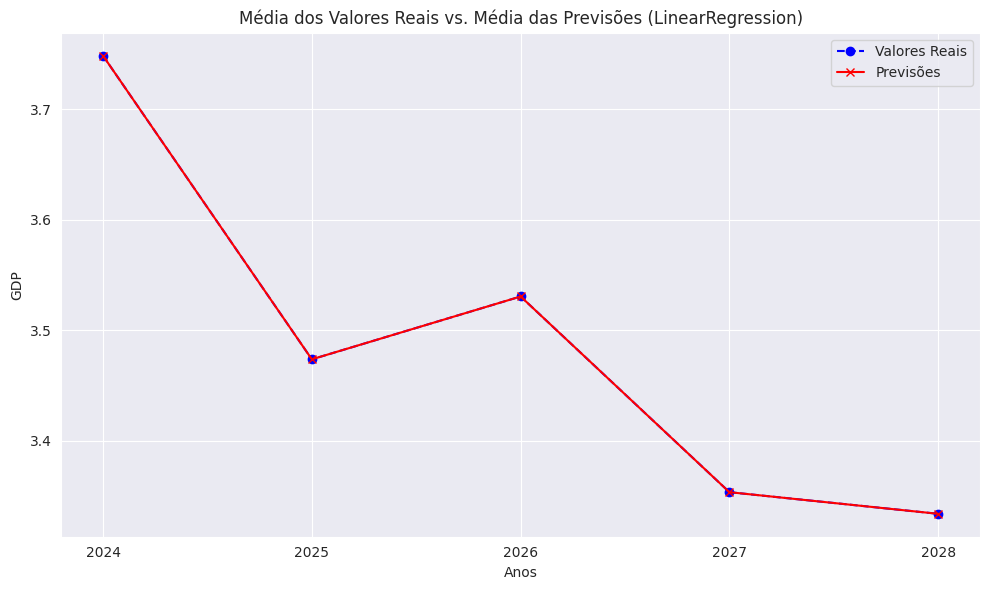

In [ ]:
# Anos de 2024 a 2028
anos = range(2024, 2029)

# Calcular os valores reais e previstos GDP para cada ano
valores_reais = y_test.mean(axis=0)
valores_previstos = np.mean(predictions_lr, axis=0)

# Plotar os resultados médios
plt.figure(figsize=(10, 6))
plt.plot(anos, valores_reais, marker='o', label='Valores Reais', linestyle='dashed', color='b')
plt.plot(anos, valores_previstos, marker='x', label='Previsões', color='r')

plt.xlabel('Anos')
plt.ylabel('GDP')
plt.title('Média dos Valores Reais vs. Média das Previsões (LinearRegression)')
plt.xticks(anos)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


**Inferência:** o gráfico mostra a proximidade das médias, entrenato o MAPE apresenta valor maior se comparado ao  modelo RandomForestRegressor .

#5. Conclusão

Após modelagem, é preciso verificar o melhor modelo por meio de uma coparação das métricas.

In [ ]:
#Tabela Comparativa

# Definir os resultados das métricas e tempos de execução para cada modelo
data = {
    'Modelo': ['ARIMA', 'SARIMA', 'XGBoost', 'RandomForest', 'LinearRegression'],
    'MAPE': [overall_mape_average_arima, overall_mape_average_sarima, overall_mape_xg_average, overall_mape_rf_average, overall_mape_lr_average],
    'RMSE': [overall_rmse_average_arima, overall_rmse_average_sarima, overall_rmse_xg_average, overall_rmse_rf_average, overall_rmse_lr_average],
    'MSE': [overall_mse_average_arima, overall_mse_average_sarima, overall_mse_xg_average, overall_mse_rf_average, overall_mse_lr_average],
    'Tempo (s)': [arima_time, sarima_time, xgboost_time, rf_time, lr_time]
}

# Criar um DataFrame com os dados
results_df_comparation = pd.DataFrame(data)

# Ordenar o DataFrame pelo nome do modelo
results_df_comparation = results_df_comparation.sort_values(by='Modelo')

# Resetar o índice
results_df_comparation = results_df_comparation.reset_index(drop=True)

# Exibir o DataFrame
results_df_comparation


Modelo       MAPE      RMSE        MSE   Tempo (s)
0             ARIMA  36.189879  1.687491  18.043601  201.150657
1  LinearRegression  32.823428  0.938739   1.261093    0.419628
2      RandomForest  11.768492  0.374848   0.599778    0.882387
3            SARIMA  95.763178  3.247453  55.952305  162.667002
4           XGBoost  12.447272  0.470467   0.221339    3.147760

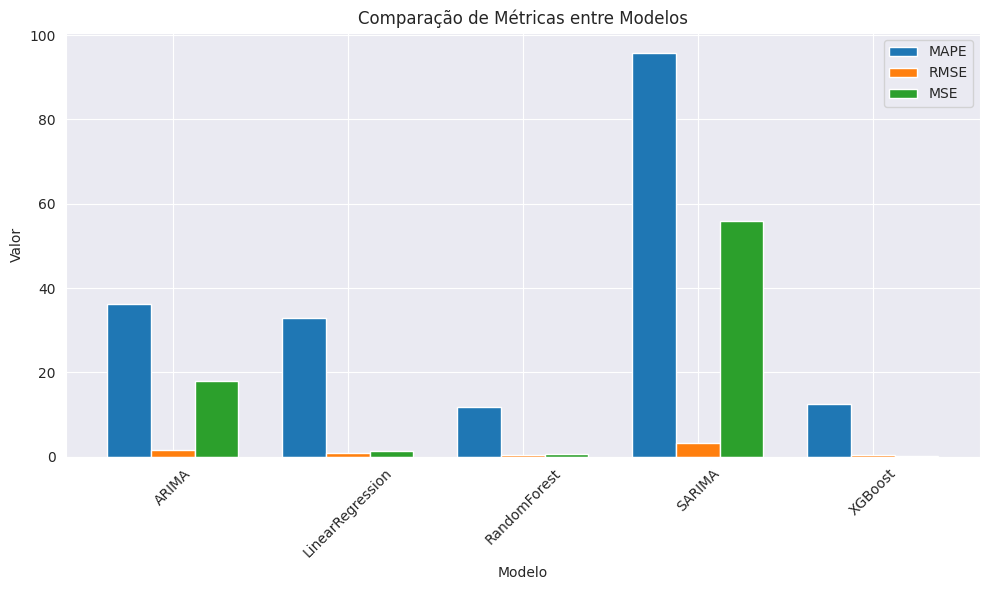

In [ ]:
#Gráfico comparativo

# Dados
modelos = results_df_comparation['Modelo']
mape = results_df_comparation['MAPE']
rmse = results_df_comparation['RMSE']
mse = results_df_comparation['MSE']

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(10, 6))  # Ajuste o tamanho da figura aqui
width = 0.25
x = range(len(modelos))

# Plotar o gráfico
ax.bar(x, mape, width, label='MAPE')
ax.bar([i + width for i in x], rmse, width, label='RMSE')
ax.bar([i + width * 2 for i in x], mse, width, label='MSE')
ax.set_xlabel('Modelo')
ax.set_ylabel('Valor')
ax.set_title('Comparação de Métricas entre Modelos')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(modelos, rotation=45)  # Rotação dos rótulos para melhor legibilidade
ax.legend()

fig.tight_layout()
plt.show()


**Inferência:** Ao comparar os resultados levando em consideração, principalmente o MAPE, o modelo RandomForestRegressor é o que teve melhor desempenho. Além disso o tempo de execução é baixo.

##5.1 Extraindo resultados

Abaixo, vamos extrair as previsões feitas pelo modelo RandomForestRegressor:

In [ ]:
# Extraindo Excel completo com as novas previsões:

# Criar uma cópia do df1 para manter as colunas originais
df0 = df1.copy()

# Selecionar as colunas de Continents, Country e os anos de 1980 a 2023
years_of_interest = [(year) for year in range(1980, 2024)]
selected_columns = ['Continents', 'Country'] + years_of_interest
df_filtered = df0[selected_columns]

# Selecionar as colunas de Continents, Country e os anos de 2024 a 2028 do predictions_df_rf
selected_columns_predictions = ['Continents', 'Country', '2024', '2025', '2026', '2027', '2028']
predictions_df_rf_2 = predictions_df_rf[selected_columns_predictions]

# Combinar os DataFrames
resultado_final = pd.merge(df_filtered, predictions_df_rf_2, on=['Continents', 'Country'])

# Salvar o resultado em um arquivo Excel e csv
resultado_final.to_excel('resultado_final.xlsx', index=False)

resultado_final.to_csv('resultado_final.csv', index=False)

# Extraindo predictions_df_rf em .csv:
predictions_df_rf.to_csv('predictions.csv', index=False)
